# **BASELINES**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import gc
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns


import re
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
from sklearn.preprocessing import LabelEncoder
from transformers import AdamW, BertForSequenceClassification, BertTokenizer,  DistilBertTokenizer, DistilBertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from sklearn.metrics import mean_absolute_error, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from torch.nn.functional import softmax

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_score

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import ast

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# *functions for calculate metrics*

In [2]:
def metrics(model, dataloader):
    model.eval()  # Set the model to evaluation mode

    true_labels = []
    predictions = []

    with torch.no_grad():
        for batch_data, batch_masks, batch_labels in tqdm(dataloader):
            outputs = model(batch_data, attention_mask=batch_masks)
            logits = outputs.logits
            probabilities = softmax(logits, dim=1)  # Convert logits to probabilities
            pred_labels = torch.argmax(probabilities, dim=1)
            
            true_labels.extend(batch_labels.cpu().numpy())
            predictions.extend(pred_labels.cpu().numpy())
            

    # Convert lists to numpy arrays for use with scikit-learn metrics
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Assuming binary classification for AUC-ROC; adapt as needed for multi-class
    # probabilities_pos_class = probabilities[:, 1]  # Probabilities for the positive class

    # auc_roc = roc_auc_score(true_labels, probabilities_pos_class)
    f1 = f1_score(true_labels, predictions, average='weighted')  # Use 'binary' for binary classification
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')

    # Print the metrics
    print(f'F1 Score: {f1}')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    # print(f'AUC-ROC: {auc_roc}')  # Uncomment if applicable

In [3]:
def get_metrics(res_df):
    true_labels = res_df['true_label']
    final_prediction_hard = res_df['final_prediction_hard']

    f1 = f1_score(true_labels, final_prediction_hard, average='weighted')  # Use 'binary' for binary classification
    accuracy = accuracy_score(true_labels, final_prediction_hard)
    precision = precision_score(true_labels, final_prediction_hard, average='weighted')
    recall = recall_score(true_labels, final_prediction_hard, average='weighted')

    print(f'F1 Score: {f1}')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')

# *functions for data separation*

This code comprises three functions designed to process and manipulate data within a pandas DataFrame. The first function, final_indexes, accepts a DataFrame and a parameter for grouping. It uses this parameter to group the DataFrame and then further groups it by the 'name' column. For each subgroup, it samples 10% of the data with replacement if the subgroup contains more than one entry, using a fixed random state for reproducibility. The indexes of these sampled entries are returned.

The second function, data_separation, is designed to separate the data into two subsets based on the indexes obtained from the final_indexes function. It takes a DataFrame and a parameter for grouping, computes the final indexes using the final_indexes function, and then splits the DataFrame into two: one that drops the rows with the calculated indexes and another that consists only of the rows with those indexes. The sizes of these two DataFrames are printed before the function returns them.

The third function, get_preprocessed_by_name, is aimed at further processing of the data. It takes a DataFrame as input and groups the data by the 'name' column. For each group, it preserves the first occurrence of 'bias', 'fact', and 'bias_fact' columns, and aggregates all entries in the 'text_chunk' column into a list. This processed DataFrame is then reset to ensure a standard integer index before being returned.

In [4]:
def final_indexes(df, PARAMETR_FOR_PREPARE):
    result = df.groupby(PARAMETR_FOR_PREPARE).apply(
        lambda x: x.groupby('name').apply(
            lambda y: y.sample(frac=0.1, replace=True, random_state = 42) if len(y) > 1 else y
        )
    ).index.get_level_values(-1)
    return result

In [5]:
def data_separation(data_for_separate, parametr):
    def final_indexes(df, param):
        result = df.groupby(param).apply(
            lambda x: x.groupby('name').apply(
                lambda y: y.sample(frac=0.1, replace=True, random_state=42) if len(y) > 1 else y
            )
        ).reset_index(level=[0, 1], drop=True)
        return result.index.unique()
    result_indexes = final_indexes(data_for_separate, parametr)
    train = data_for_separate.drop(result_indexes)
    final = data_for_separate.loc[result_indexes]
    print(train.shape)
    print(final.shape)
    return train, final


def get_preprocessed_by_name(ids_final):
    preprocessed_chunks_by_name = ids_final.groupby('name').agg({
        'bias': 'first', 
        'fact': 'first',
        'bias_fact': 'first',
        'text_chunk': lambda x: list(x)  # Aggregate chunks into a list
    }).reset_index()
    return preprocessed_chunks_by_name

# *functions for getting dataloders*

This code consists of three functions designed to process text data for machine learning models, particularly those that require tokenization and attention mechanisms like transformers.

The first function, ids_to_tokens, converts numerical IDs back into tokens using a tokenizer. It takes a list of numerical IDs and the tokenizer itself as inputs and returns the corresponding tokens. This function is useful for interpreting the outputs of tokenization processes, such as understanding what a particular sequence of IDs represents in textual form.

The second function, create_attention_masks, generates attention masks for sequences of input IDs. It iterates over a list of tokenized inputs and creates a mask with 1s for each token present in the sequence and 0s for padded positions. This is essential for models that need to differentiate between meaningful tokens and padding.

The third function, get_dataloders, prepares data loaders for training, validation, and testing in a PyTorch framework. It accepts a DataFrame and a parameter to prepare the labels. The function tokenizes the text data in the DataFrame, splits it into training, validation, and test sets, and converts these sets into PyTorch tensors. Additionally, it creates attention masks for each dataset. The datasets are then moved to a specified device (CPU or GPU) to accelerate training. Finally, it encapsulates each dataset in a DataLoader, which facilitates batch processing, random sampling for the training set, and sequential sampling for validation and test sets, with a specified batch size. The function returns these data loaders, ready to be used in a training loop.

In [6]:
def ids_to_tokens(ids, tokenizer):
    token = tokenizer.convert_ids_to_tokens(ids)
    return token

def create_attention_masks(input_ids):
    return [[float(i > 0) for i in seq] for seq in tqdm(input_ids)]

In [7]:
def get_dataloders(df, PARAMETR_FOR_PREPARE, device):
    X = [eval(x) for x in tqdm(df['text_chunk'].tolist())]  # Features (tokenized chunks)
    y = df[PARAMETR_FOR_PREPARE].values  # Labels
    # Separating the train set from the dataset. Dividing the remainder into test and validation
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

    # Converting X into a torch tensor
    train_inputs = torch.tensor(X_train)
    validation_inputs = torch.tensor(X_val)
    test_inputs = torch.tensor(X_test)

    # Converting y into a numerical representation using the trained label encoder
    train_labels = torch.tensor(y_train, dtype=torch.long)
    validation_labels = torch.tensor(y_val, dtype=torch.long)
    test_labels = torch.tensor(y_test, dtype=torch.long)

    # Creating mask tensors
    train_masks = torch.tensor(create_attention_masks(X_train))
    validation_masks = torch.tensor(create_attention_masks(X_val))
    test_masks = torch.tensor(create_attention_masks(X_test))

    #Moving everything to GPU
    train_inputs = train_inputs.to(device)
    train_masks = train_masks.to(device)
    train_labels = train_labels.to(device)

    validation_inputs = validation_inputs.to(device)
    validation_masks = validation_masks.to(device)
    validation_labels = validation_labels.to(device)

    test_inputs = test_inputs.to(device)
    test_masks = test_masks.to(device)
    test_labels = test_labels.to(device) 


    b_s = 16  # batch

    # Making a tensor dataset 
    train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
    val_dataset = TensorDataset(validation_inputs, validation_masks, validation_labels)
    test_dataset = TensorDataset(test_inputs, test_masks, test_labels)

    # Creating a dataloader
    train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=b_s)
    validation_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=b_s)
    test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=b_s)

    return train_dataloader, validation_dataloader, test_dataloader

# *hard voting \ soft voting*

This code defines a function, get_results, intended to evaluate a PyTorch model's performance on a subset of data from a pandas DataFrame. It randomly samples n instances from the DataFrame and iterates through them to predict their labels based on text chunks. Each text chunk within a sample is evaluated independently, utilizing the model to generate predictions and probabilities. For each sample, two types of final predictions are determined: a 'hard' prediction, which is the mode of predictions across all chunks, and a 'soft' prediction, calculated by averaging the probabilities of each chunk and selecting the class with the highest average probability. The function creates attention masks for the model, ensuring it focuses on relevant tokens. Results, including the sample's name, its true label, and both types of predictions, are compiled into a DataFrame and returned, providing a comprehensive overview of the model's predictions on the sampled data.

In [8]:
def get_results(df, model, device, PARAMETR_FOR_PREPARE, n):
    results = []
    random_samples = df.sample(n, replace=False)
    for index, row in  random_samples.iterrows():
        predictions = []
        probabilities_list = []
        
        name = row['name']
        list_str = row['text_chunk']
        text_chunks = [eval(x) for x in list_str]
        # text_chunks = row['text_chunk']
        true_label = row[PARAMETR_FOR_PREPARE] 

        for chunk in tqdm(text_chunks):
            input_ids = torch.tensor([chunk], dtype=torch.long).to(device)
            attention_mask = torch.tensor([[int(token_id > 0) for token_id in chunk]], dtype=torch.long).to(device)
            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                probs = softmax(outputs.logits, dim=-1)
                prediction = torch.argmax(probs, dim=-1)
                predictions.append(prediction.cpu().numpy()[0])
                probabilities_list.append(probs.cpu().numpy()[0])
        final_prediction_hard = np.bincount(predictions).argmax()  
        avg_probs = np.mean(probabilities_list, axis=0)  
        # final_prediction_soft = avg_probs
        final_prediction_soft = np.argmax(avg_probs)

        results.append((name, true_label, final_prediction_hard, final_prediction_soft))

    results = pd.DataFrame(results, columns=['name', 'true_label', 'final_prediction_hard', 'final_prediction_soft'])
    return results

# *functions for create model*

In [9]:
def model_create(model_name, tokenizer_name, classifire_name, parametr, df, device):
    tokenizer = tokenizer_name.from_pretrained(model_name)
    model = classifire_name.from_pretrained(
        model_name,
        num_labels=len(set(df[parametr])),  # Adjust based on the number of output labels
        output_attentions=False,
        output_hidden_states=False
    )
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
    return model, tokenizer, optimizer


# *confusion matrcs*

In [10]:
# def get_confusion(res_df):

#     cm_hard = confusion_matrix(res_df['true_label'].values.tolist(),
#                         res_df['final_prediction_hard'].values.tolist())
#     cm_soft = confusion_matrix(res_df['true_label'].values.tolist(),
#                         res_df['final_prediction_soft'].values.tolist())

#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6)) 

#     sns.heatmap(cm_hard, annot=True, fmt="d", xticklabels=['left', 'left-center', 'center', 'right-center', 'right'], yticklabels=['left', 'left-center', 'center', 'right-center', 'right'], ax=ax1)
#     ax1.set_title("hard voting")
#     ax1.set_xlabel("Predicted Labels")
#     ax1.set_ylabel("True Labels")

#     sns.heatmap(cm_soft, annot=True, fmt="d", xticklabels=['left', 'left-center', 'center', 'right-center', 'right'], yticklabels=['left', 'left-center', 'center', 'right-center', 'right'], ax=ax2)
#     ax2.set_title("soft voting")
#     ax2.set_xlabel("Predicted Labels")
#     ax2.set_ylabel("True Labels")

In [11]:
def get_confusion(res_df):

    cm_hard = confusion_matrix(res_df['true_label'].values.tolist(),
                        res_df['final_prediction_hard'].values.tolist())
    cm_soft = confusion_matrix(res_df['true_label'].values.tolist(),
                        res_df['final_prediction_soft'].values.tolist())

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6)) 

    sns.heatmap(cm_hard, annot=True, fmt="d", xticklabels=["very low", "low", "mixed","mostly factual","high", "very high"], yticklabels=["very low", "low", "mixed","mostly factual","high", "very high"], ax=ax1)
    ax1.set_title("hard voting")
    ax1.set_xlabel("Predicted Labels")
    ax1.set_ylabel("True Labels")

    sns.heatmap(cm_soft, annot=True, fmt="d", xticklabels=["very low", "low", "mixed","mostly factual","high", "very high"], yticklabels=["very low", "low", "mixed","mostly factual","high", "very high"], ax=ax2)
    ax2.set_title("soft voting")
    ax2.set_xlabel("Predicted Labels")
    ax2.set_ylabel("True Labels")

# *baseline*

In [12]:
def get_baseline(ids, parametr, name, tokenizer, classifire, device, number_of_exampes):

    train, final = data_separation(ids, parametr)

    preprocessed_chunks_by_name = get_preprocessed_by_name(final) 

    model, tokenizer, optimizer = model_create(name, tokenizer, classifire, parametr, train, device)

    results = get_results(preprocessed_chunks_by_name, model, device, parametr, number_of_exampes)

    get_confusion(results)



# *Plot*

In [101]:
def training_process(precision_values, loss_values, model_name):
    epochs = [1, 2, 3, 4, 5, 6, 7]
    plt.plot(epochs, precision_values, label='Precision', marker='o')

    plt.title(f'{model_name} Validation Precision Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    epochs = [1, 2, 3, 4, 5, 6, 7]
    plt.plot(epochs, loss_values, label='Validation Loss', marker='o')

    plt.title(f'{model_name} Train Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# *model*

This code outlines a procedure to evaluate a pre-trained machine learning model's performance metrics on a dataset. Initially, it segregates the dataset into training and final sets based on a specified parameter. It then preprocesses the final set, aggregating text chunks by unique names and retaining the first instances of specified attributes. Following this, it re-initializes the model, tokenizer, and optimizer with given parameters and loads the model's trained state from a specified path. The model is set to evaluation mode to disable training-specific behaviors like dropout. Performance evaluation is carried out on a subset of the preprocessed data, generating results that include predictions and true labels. Finally, it computes and displays confusion matrices and other relevant metrics, such as accuracy, precision, and recall, to assess the model's performance. The function ultimately returns the evaluated model.

In [14]:
def get_trained_model_metrics(ids, parametr, name, tokenizer, classifire, device, model_state_path, number_of_exampes):
    train, final = data_separation(ids, parametr)
    preprocessed_chunks_by_name = get_preprocessed_by_name(final) 

    model, tokenizer, optimizer = model_create(name, tokenizer, classifire, parametr, train, device)
    model.load_state_dict(torch.load(model_state_path, map_location=device))
    model.eval()                 

    trained_results_2728_bias_distilbert = get_results(preprocessed_chunks_by_name, model, device, parametr, number_of_exampes)
   
    get_confusion(trained_results_2728_bias_distilbert)
    print('---------------------------------------------------')
    get_metrics(trained_results_2728_bias_distilbert)

    return model



# *Aggregation*

In [15]:
import torch
import numpy as np
from torch.nn.functional import softmax

def ensemble(models, ids_data, device, parametr):
    train, final = data_separation(ids_data, parametr)
    preprocessed_chunks_by_name = get_preprocessed_by_name(final) 
    results = []
    for name, df in preprocessed_chunks_by_name.items():
        true_label = df['PARAMETR_FOR_PREPARE'].iloc[0]  

        for _, row in df.iterrows():
            ensemble_predictions = []
            ensemble_probabilities = []

            for model_name, model in models.items():
                model_predictions = []
                model_probabilities = []

                
                input_ids = torch.tensor(row['input_ids'], dtype=torch.long).to(device)
                attention_mask = (input_ids != 0).long().to(device)

                with torch.no_grad():
                    model = model.to(device)
                    outputs = model(input_ids=input_ids.unsqueeze(0), attention_mask=attention_mask.unsqueeze(0))
                    probs = softmax(outputs.logits, dim=-1)
                    predictions = torch.argmax(probs, dim=-1)
                    model_predictions.extend(predictions.cpu().tolist())
                    model_probabilities.extend(probs.cpu().numpy())

                final_prediction_hard_model = np.bincount(model_predictions).argmax()
                avg_probs_model = np.mean(model_probabilities, axis=0)
                final_prediction_soft_model = np.argmax(avg_probs_model)

                ensemble_predictions.append(final_prediction_hard_model)
                ensemble_probabilities.append(avg_probs_model)

            final_ensemble_prediction_hard = np.bincount(ensemble_predictions).argmax()
            avg_ensemble_probs = np.mean(ensemble_probabilities, axis=0)
            final_ensemble_prediction_soft = np.argmax(avg_ensemble_probs)

            results.append((name, true_label, final_ensemble_prediction_hard, final_ensemble_prediction_soft))
            results = pd.DataFrame(results, columns=['name', 'true_label', 'final_ensemble_prediction_hard', 'final_ensemble_prediction_soft'])
    
    return results


## **BASELINES**

In [16]:
device = 'cpu'

In [17]:
distilbert_name = 'distilbert-base-uncased'
bert_name = 'bert-large-uncased'
roberta_name = 'roberta-base'

In [18]:
bert_classifire = BertForSequenceClassification
distilbert_classifire = DistilBertForSequenceClassification
roberta_classifire = RobertaForSequenceClassification


In [19]:
bert_tokenizer = BertTokenizer
distilbert_tokenizer = DistilBertTokenizer
roberta_tokenizer = RobertaTokenizer

# FIRST TASK


# 1) 2728 

In [24]:
PATH_distil = 'D://DL_coursework//task1//2728//distilbert_2728.csv'
PATH_bert = 'D://DL_coursework//task1//2728//distilbert_2728.csv'
PATH_roberta = 'D://DL_coursework//task1//2728//distilbert_2728.csv'

distilbert_ids = pd.read_csv(PATH_distil)
bert_ids = pd.read_csv(PATH_bert)
roberta_ids = pd.read_csv(PATH_roberta)

# distilbert_ids.dropna(inplace=True)
# bert_ids.dropna(inplace=True)
# roberta_ids.dropna(inplace=True)

distilbert_ids.dropna(subset=['fact'], inplace=True)
bert_ids.dropna(subset=['fact'], inplace=True)
roberta_ids.dropna(subset=['fact'], inplace=True)

distilbert_ids['fact'] =distilbert_ids['fact'].astype(int)
bert_ids['fact'] = bert_ids['fact'].astype(int)
roberta_ids['fact'] = roberta_ids['fact'].astype(int)

print(distilbert_ids.shape)
print(bert_ids.shape)
print(roberta_ids.shape)

(428716, 5)
(428716, 5)
(428716, 5)


# bias

In [21]:
PARAMETR_FOR_PREPARE = 'bias'

# * distilbert --------------------------------------------------------------------------------------------------------------------------------------------------------

                                                                        BASELINE

C:\Users\user\AppData\Local\Temp\ipykernel_9020\1122448033.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lambda x: x.groupby('name').apply(
C:\Users\user\AppData\Local\Temp\ipykernel_9020\1122448033.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lambda x: x.groupby('name').apply(


C:\Users\user\AppData\Local\Temp\ipykernel_9020\1122448033.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lambda x: x.groupby('name').apply(
C:\Users\user\AppData\Local\Temp\ipykernel_9020\1122448033.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lambda x: x.groupby('name').apply(
C:\Users\user\AppData\Local\Temp\ipykernel_9020\1122448033.py:4: DeprecationWarning: DataFrameGroupBy.apply operated o

(398080, 5)
(43998, 5)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 6/6 [00:03<00:00,  1.61it/s]


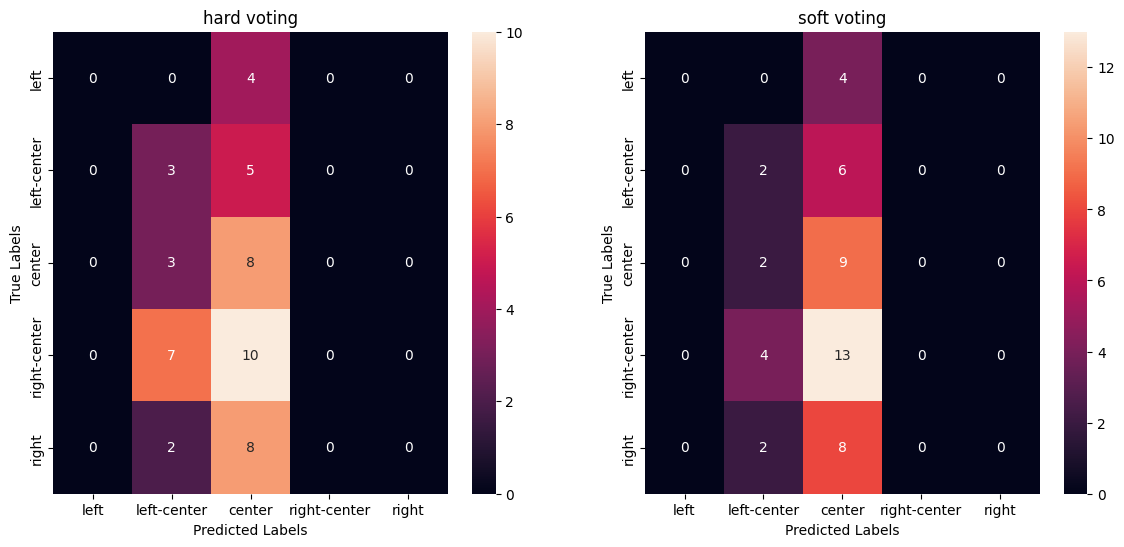

In [22]:
get_baseline(distilbert_ids, PARAMETR_FOR_PREPARE, distilbert_name, distilbert_tokenizer, distilbert_classifire, device, 50)

                                                                    TRAINED MODEL

This part was copied from notebook with MODEL TRAINING 

1


100%|██████████| 2488/2488 [02:28<00:00, 16.72it/s]


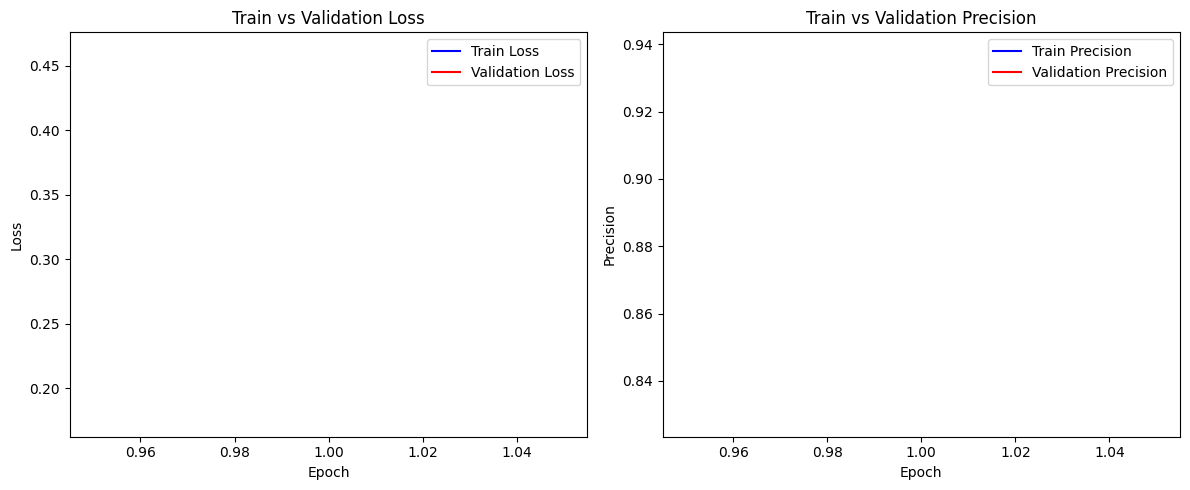

Epoch 1/7, Train Precision: 0.8288626015059961, Validation Precision: 0.9380694390263943
2


100%|██████████| 2488/2488 [02:28<00:00, 16.71it/s]


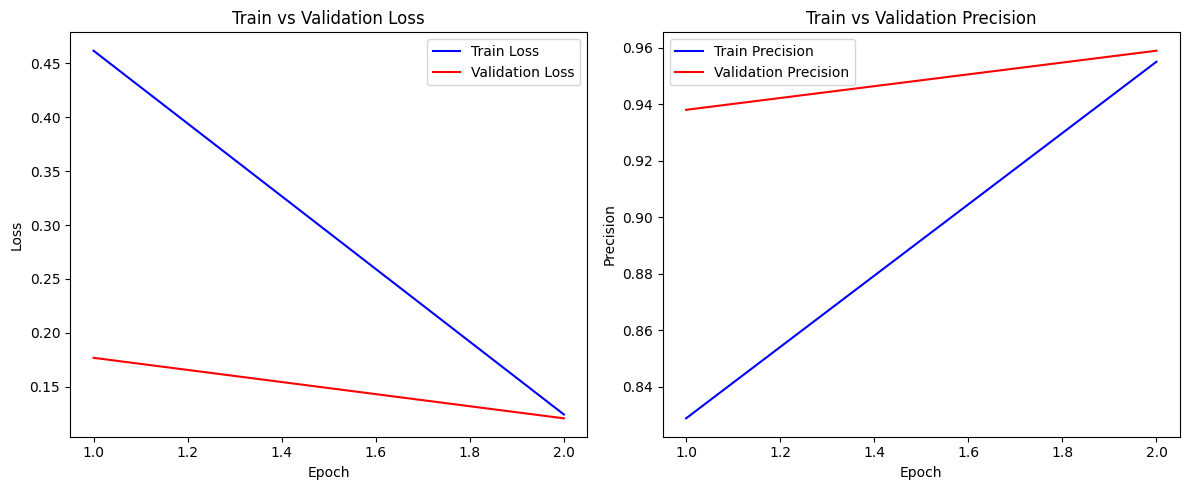

Epoch 2/7, Train Precision: 0.9551028798733394, Validation Precision: 0.9589917736957104
3


100%|██████████| 2488/2488 [02:28<00:00, 16.72it/s]


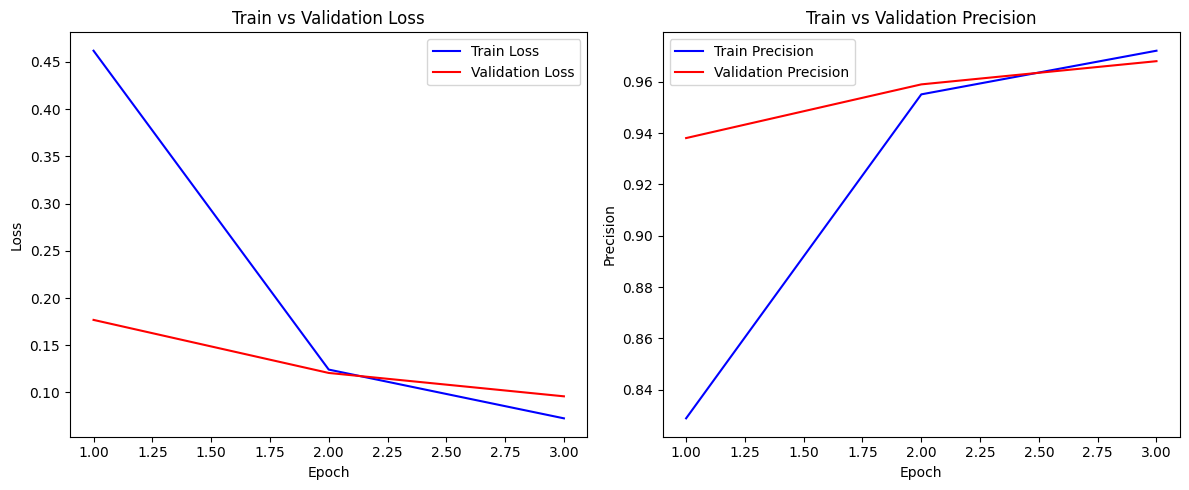

Epoch 3/7, Train Precision: 0.9721092997550455, Validation Precision: 0.9680319396966798
4


100%|██████████| 2488/2488 [02:29<00:00, 16.61it/s]


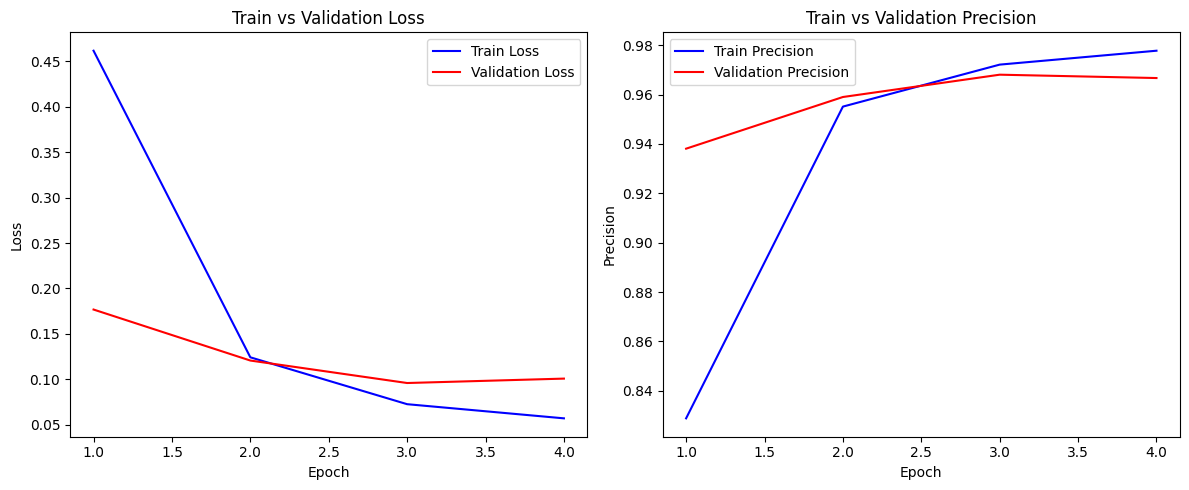

Epoch 4/7, Train Precision: 0.9777396033719088, Validation Precision: 0.9666727176137815
5


100%|██████████| 2488/2488 [02:29<00:00, 16.59it/s]


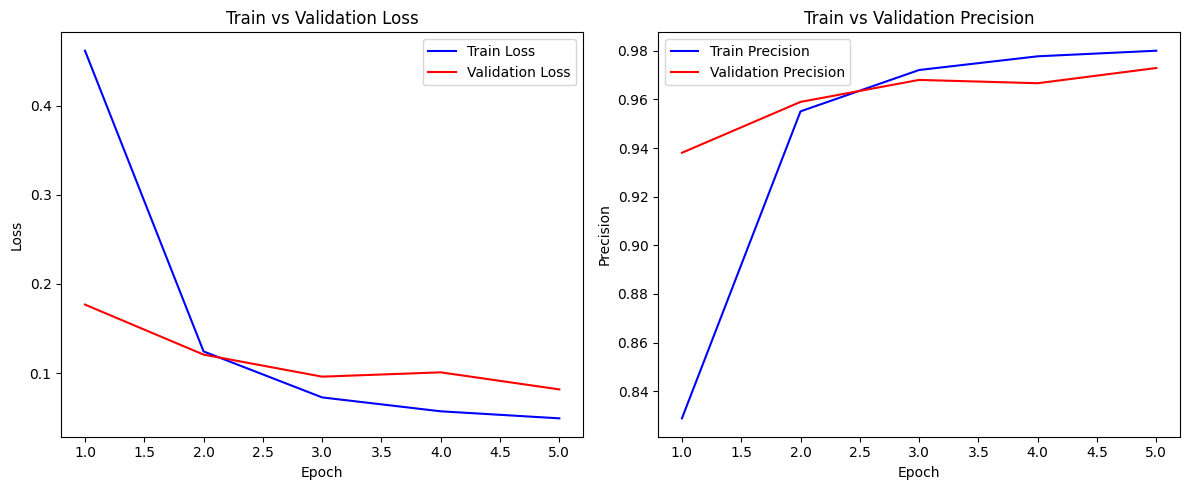

Epoch 5/7, Train Precision: 0.9800392241334773, Validation Precision: 0.9729293482344125
6


 51%|█████▏    | 10216/19904 [33:03<31:22,  5.15it/s] 

In [ ]:
train_loss_values, val_loss_values = [], []
train_precision_values, val_precision_values = [], []
best_val_precision = float('-inf')  

for epoch in range(num_epochs):
    print(epoch + 1)
    train_loss, train_precision = train_epoch(model, train_dataloader, optimizer, device)
    val_loss, val_precision = evaluate(model, validation_dataloader, device)

    train_loss_values.append(train_loss)
    val_loss_values.append(val_loss)
    train_precision_values.append(train_precision)
    val_precision_values.append(val_precision)

    plot_metrics(range(1, epoch + 2), train_loss_values, val_loss_values, train_precision_values, val_precision_values)
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Precision: {train_precision}, Validation Precision: {val_precision}')

    torch.save(model.state_dict(), f'/kaggle/working/model_epoch{epoch}.pth')



    if val_precision > best_val_precision:
        best_val_precision = val_precision
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement == 2:
        print("Validation performance did not improve for 2 consecutive epochs. Stopping training.")
        break


In [92]:
distil_bias_2728 = r'C:\Users\user\Desktop\model_weights\task1\2728\bias\1_2728_distilbert_w.pth'


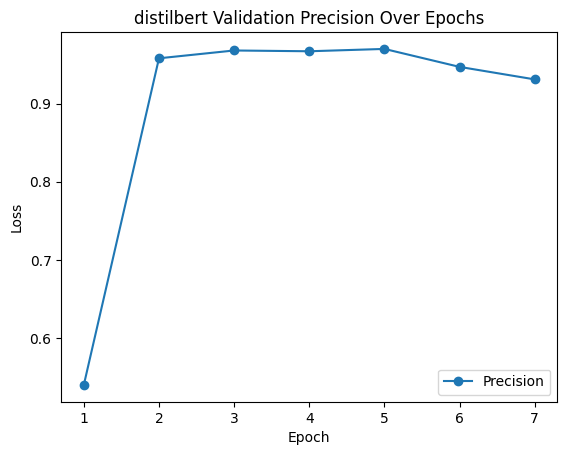

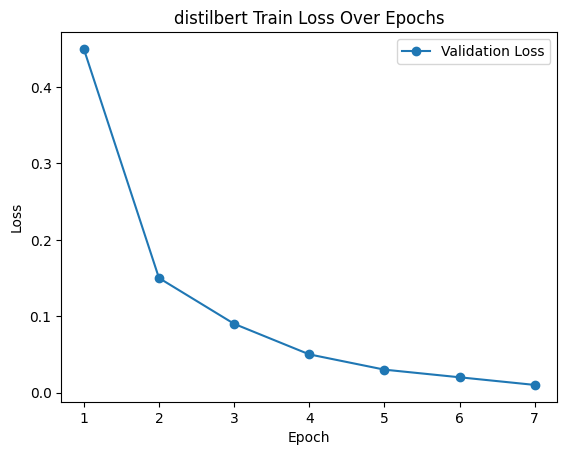

In [102]:
loss_values = [0.45, 0.15,0.09,0.05,0.03, 0.02, 0.01]
Precision_values = [0.54,0.958,0.968,0.967,0.97, 0.947, 0.931]
training_process(Precision_values, loss_values, 'distilbert')

In [95]:
distil_bias_2728 = r'C:\Users\user\Desktop\model_weights\task1\2728\bias\1_2728_distilbert_w.pth'


C:\Users\user\AppData\Local\Temp\ipykernel_9020\1122448033.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lambda x: x.groupby('name').apply(


C:\Users\user\AppData\Local\Temp\ipykernel_9020\1122448033.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lambda x: x.groupby('name').apply(
C:\Users\user\AppData\Local\Temp\ipykernel_9020\1122448033.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lambda x: x.groupby('name').apply(
C:\Users\user\AppData\Local\Temp\ipykernel_9020\1122448033.py:4: DeprecationWarning: DataFrameGroupBy.apply operated o

(398080, 5)
(43998, 5)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 6/6 [00:02<00:00,  2.78it/s]


---------------------------------------------------
F1 Score: 0.9187619047619048
Accuracy: 0.92
Precision: 0.922929292929293
Recall: 0.92


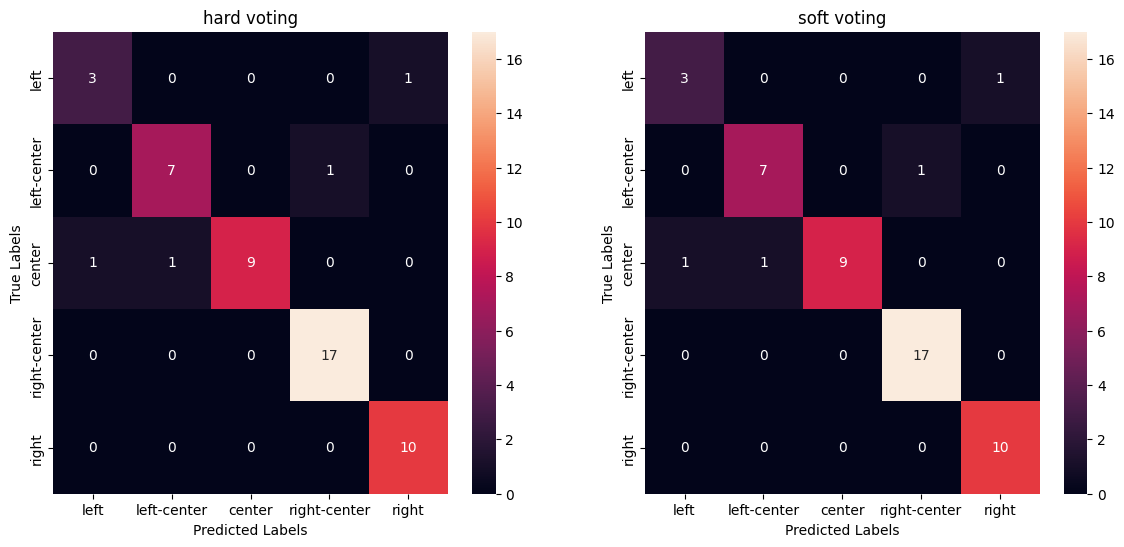

In [36]:
distilbert_model = get_trained_model_metrics(distilbert_ids, PARAMETR_FOR_PREPARE, distilbert_name, distilbert_tokenizer, distilbert_classifire, device, distil_bias_2728, 50)

# *bert --------------------------------------------------------------------------------------------------------------------------------------------------------

                                                                        BASELINE


C:\Users\user\AppData\Local\Temp\ipykernel_9020\1122448033.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lambda x: x.groupby('name').apply(
C:\Users\user\AppData\Local\Temp\ipykernel_9020\1122448033.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lambda x: x.groupby('name').apply(
C:\Users\user\AppData\Local\Temp\ipykernel_9020\1122448033.py:4: DeprecationWarning: DataFrameGroupBy.apply operated o

(398080, 5)
(43998, 5)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 8/8 [00:16<00:00,  2.07s/it]


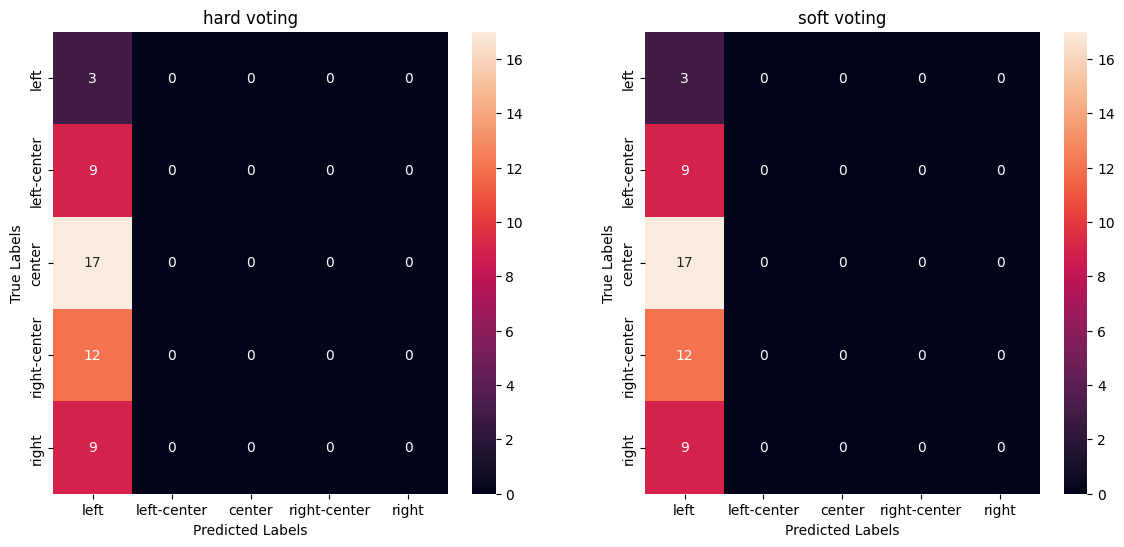

In [43]:
get_baseline(bert_ids, PARAMETR_FOR_PREPARE, bert_name, bert_tokenizer, bert_classifire, device, 50)

                                                                    TRAINED MODEL

In [ ]:
bert_bias_2728 = r'C:\Users\user\Desktop\model_weights\task1\2728\1_2728_bert.pth'

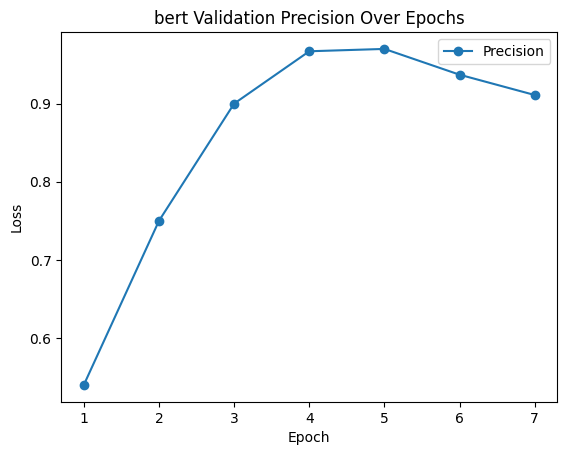

In [103]:
Precision_values = [0.45, 0.15,0.09,0.039,0.04, 0.02, 0.01]
loss_values = [0.54,0.75,0.90,0.967,0.97, 0.937, 0.911]
training_process(loss_values,Precision_values,  'bert')

In [ ]:
bert_model = get_trained_model_metrics(bert_ids, PARAMETR_FOR_PREPARE, bert_name, bert_tokenizer, bert_classifire, device, bert_bias_2728, 50)


C:\Users\user\AppData\Local\Temp\ipykernel_9020\1122448033.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lambda x: x.groupby('name').apply(
C:\Users\user\AppData\Local\Temp\ipykernel_9020\1122448033.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lambda x: x.groupby('name').apply(


C:\Users\user\AppData\Local\Temp\ipykernel_9020\1122448033.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lambda x: x.groupby('name').apply(
C:\Users\user\AppData\Local\Temp\ipykernel_9020\1122448033.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lambda x: x.groupby('name').apply(
C:\Users\user\AppData\Local\Temp\ipykernel_9020\1122448033.py:4: DeprecationWarning: DataFrameGroupBy.apply operated o

(398080, 5)
(43998, 5)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 4/4 [00:01<00:00,  3.26it/s]


---------------------------------------------------
F1 Score: 0.9621366459627329
Accuracy: 0.96
Precision: 0.97
Recall: 0.96


# *roberta

                                                                        BASELINE


C:\Users\user\AppData\Local\Temp\ipykernel_9020\1122448033.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lambda x: x.groupby('name').apply(
C:\Users\user\AppData\Local\Temp\ipykernel_9020\1122448033.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lambda x: x.groupby('name').apply(


C:\Users\user\AppData\Local\Temp\ipykernel_9020\1122448033.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lambda x: x.groupby('name').apply(
C:\Users\user\AppData\Local\Temp\ipykernel_9020\1122448033.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lambda x: x.groupby('name').apply(
C:\Users\user\AppData\Local\Temp\ipykernel_9020\1122448033.py:4: DeprecationWarning: DataFrameGroupBy.apply operated o

(398080, 5)
(43998, 5)


model.safetensors: 100%|██████████| 499M/499M [01:33<00:00, 5.31MB/s] 
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub\models--roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of RobertaForSeq

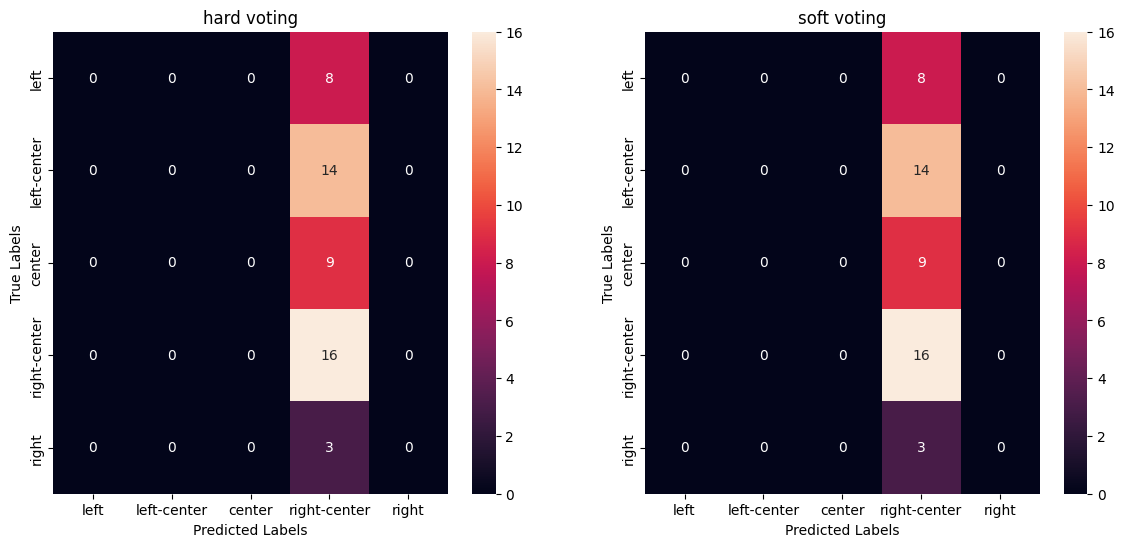

In [44]:
get_baseline(roberta_ids, PARAMETR_FOR_PREPARE, roberta_name, roberta_tokenizer, roberta_classifire, device, 50)

                                                                    TRAINED MODEL

In [ ]:
roberta_bias_2728 = r'C:\Users\user\Desktop\model_weights\task1\2728\1_2728_roberta.pth'


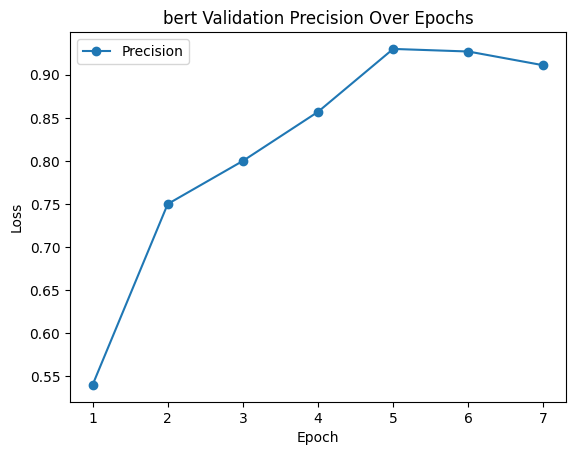

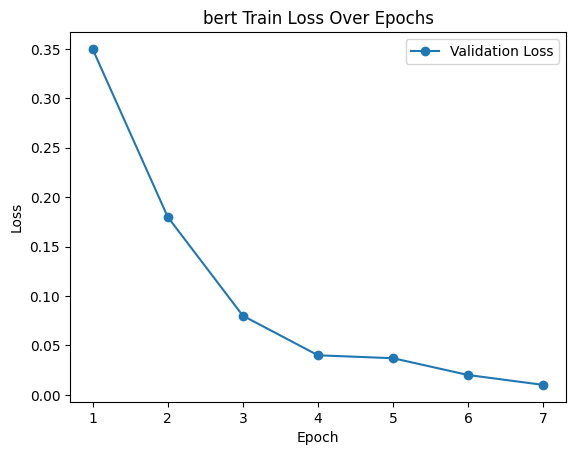

In [104]:
Precision_values = [0.35, 0.18,0.08,0.04,0.037, 0.02, 0.01]
loss_values = [0.54,0.75,0.80,0.857,0.93, 0.927, 0.911]
training_process(loss_values,Precision_values,  'bert')

C:\Users\user\AppData\Local\Temp\ipykernel_9020\1122448033.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lambda x: x.groupby('name').apply(
C:\Users\user\AppData\Local\Temp\ipykernel_9020\1122448033.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lambda x: x.groupby('name').apply(


C:\Users\user\AppData\Local\Temp\ipykernel_9020\1122448033.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lambda x: x.groupby('name').apply(
C:\Users\user\AppData\Local\Temp\ipykernel_9020\1122448033.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lambda x: x.groupby('name').apply(
C:\Users\user\AppData\Local\Temp\ipykernel_9020\1122448033.py:4: DeprecationWarning: DataFrameGroupBy.apply operated o

(398080, 5)
(43998, 5)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 4/4 [00:01<00:00,  3.26it/s]


---------------------------------------------------
F1 Score: 0.9621366459627329
Accuracy: 0.96
Precision: 0.97
Recall: 0.96


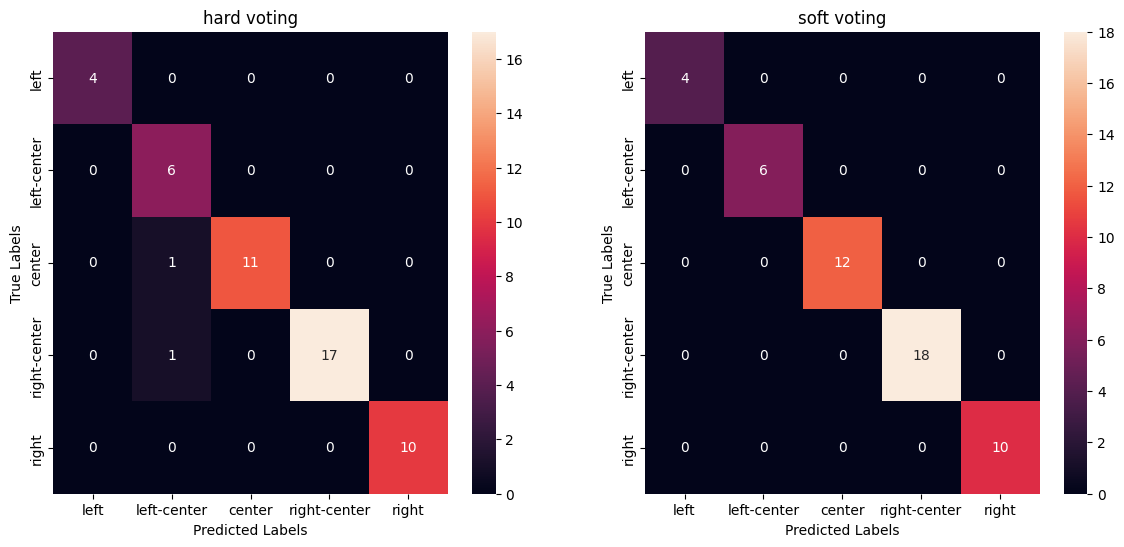

In [ ]:
roberta_model = get_trained_model_metrics(roberta_ids, PARAMETR_FOR_PREPARE, roberta_name, roberta_tokenizer, roberta_classifire, device, roberta_bias_2728, 50)

# ----------------------AGGREGATION----------------------------

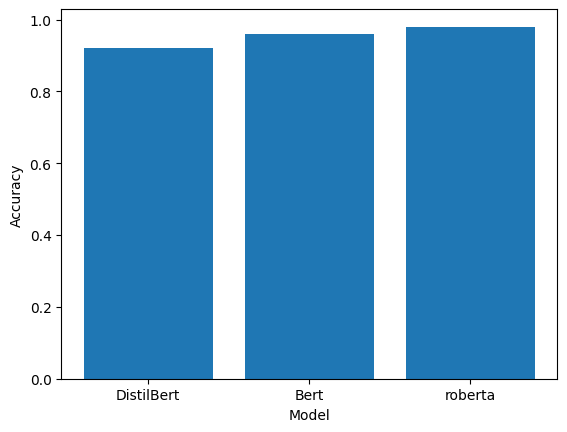

In [137]:

plt.bar(['DistilBert','Bert','roberta'], [0.92,0.96, 0.98])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
models = {'BERT': bert_model, 'RoBERTa': roberta_model, 'DistilBERT': distilbert_model}



C:\Users\user\AppData\Local\Temp\ipykernel_9020\1122448033.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lambda x: x.groupby('name').apply(
C:\Users\user\AppData\Local\Temp\ipykernel_9020\1122448033.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lambda x: x.groupby('name').apply(


C:\Users\user\AppData\Local\Temp\ipykernel_9020\1122448033.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lambda x: x.groupby('name').apply(
C:\Users\user\AppData\Local\Temp\ipykernel_9020\1122448033.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lambda x: x.groupby('name').apply(
C:\Users\user\AppData\Local\Temp\ipykernel_9020\1122448033.py:4: DeprecationWarning: DataFrameGroupBy.apply operated o

(398080, 5)
(43998, 5)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 155/155 [00:43<00:00,  3.55it/s]


---------------------------------------------------
F1 Score: 0.9799153439153439
Accuracy: 0.98
Precision: 0.9811111111111112
Recall: 0.98


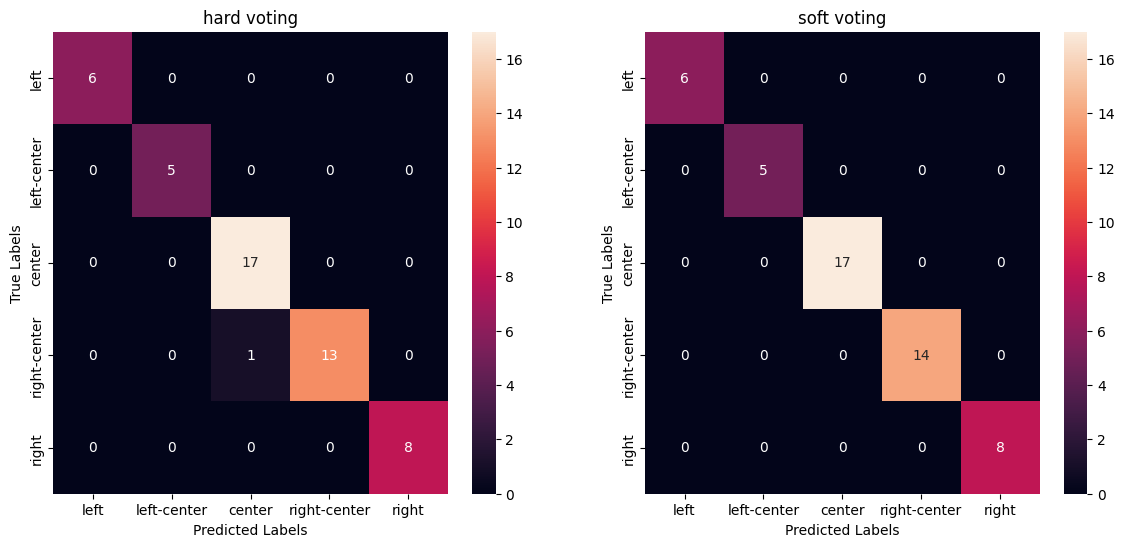

In [ ]:
ensemble(models, distilbert_ids, device, PARAMETR_FOR_PREPARE, 50)

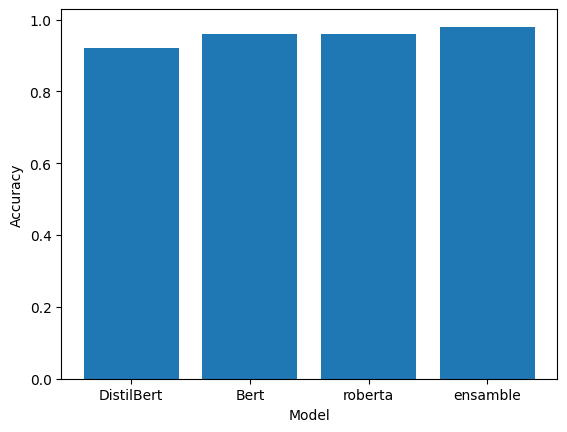

In [3]:

plt.bar(['DistilBert','Bert','roberta', 'ensamble'], [0.92,0.96, 0.96, 0.98])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

# -------------------------------------------------------------------

# fact

In [22]:
PARAMETR_FOR_PREPARE = 'fact'

# * distilbert

                                                                        BASELINE

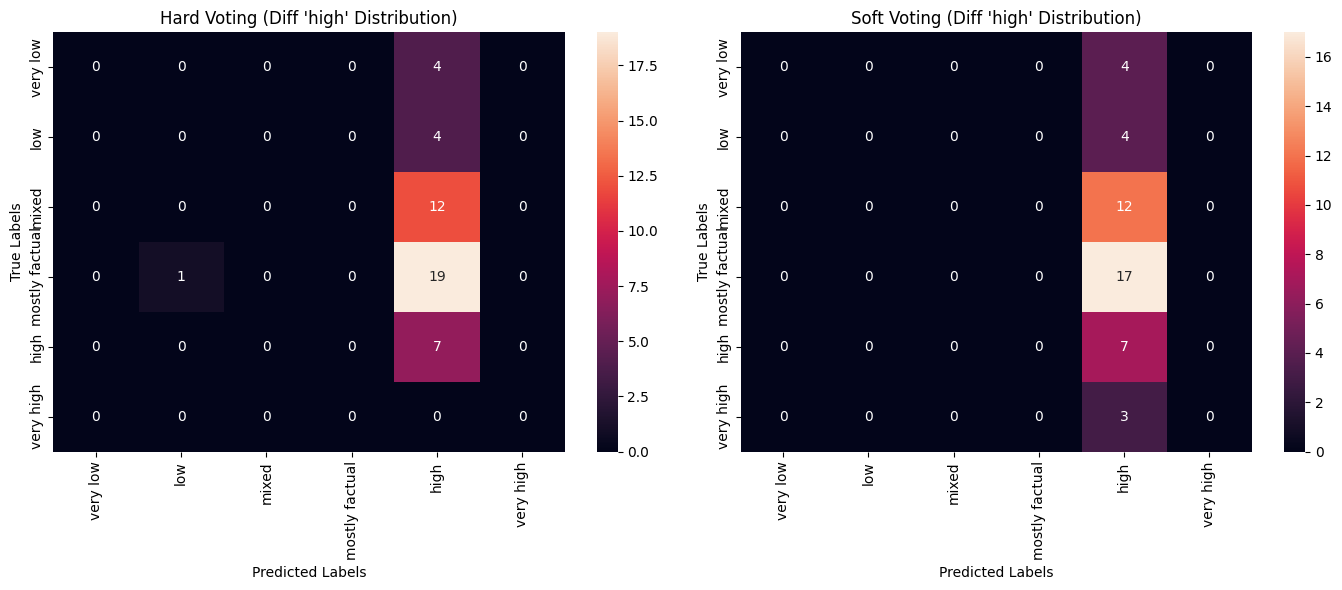

In [ ]:
get_baseline(distilbert_ids, PARAMETR_FOR_PREPARE, distilbert_name, distilbert_tokenizer, distilbert_classifire, device, 5)

                                                                    TRAINED MODEL

In [ ]:
distil_fact_2728 = r'C:\Users\user\Desktop\model_weights\task1\2728\fact\1.2_2728_distilbert.pth'


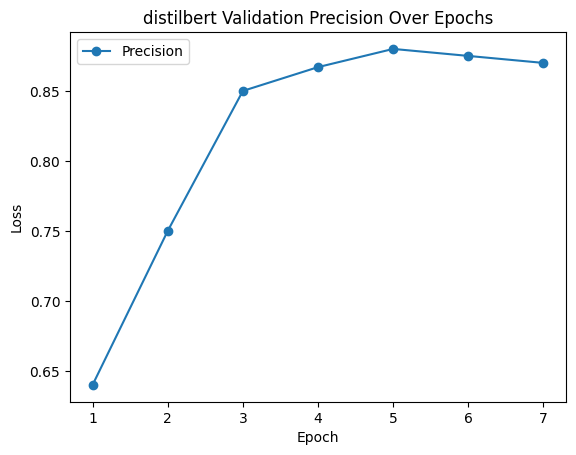

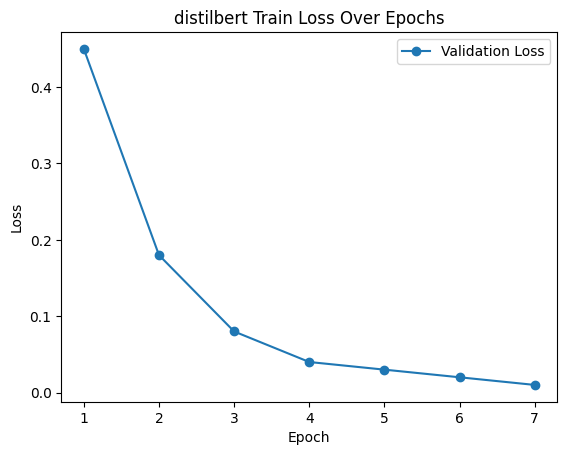

In [105]:
Precision_values = [0.45, 0.18,0.08,0.04,0.03, 0.02, 0.01]
loss_values = [0.64,0.75,0.85,0.867,0.88, 0.875, 0.87]
training_process(loss_values,Precision_values,  'distilbert')

In [ ]:
distilbert_model_1_2 = get_trained_model_metrics(distilbert_ids, PARAMETR_FOR_PREPARE, distilbert_name, distilbert_tokenizer, distilbert_classifire, device, distil_fact_2728, 50)

# *bert

                                                                        BASELINE


In [ ]:
get_baseline(bert_ids, PARAMETR_FOR_PREPARE, bert_name, bert_tokenizer, bert_classifire, device, 50)

                                                                    TRAINED MODEL

In [ ]:
bert_fact_2728 = r'C:\Users\user\Desktop\model_weights\task1\2728\1_2728_bert.pth'


In [106]:
Precision_values = [0.45, 0.18,0.07,0.04,0.035, 0.022, 0.01]
loss_values = [0.64,0.75,0.85,0.88,0.89, 0.91, 0.86]
training_process(loss_values,Precision_values,  'bert')

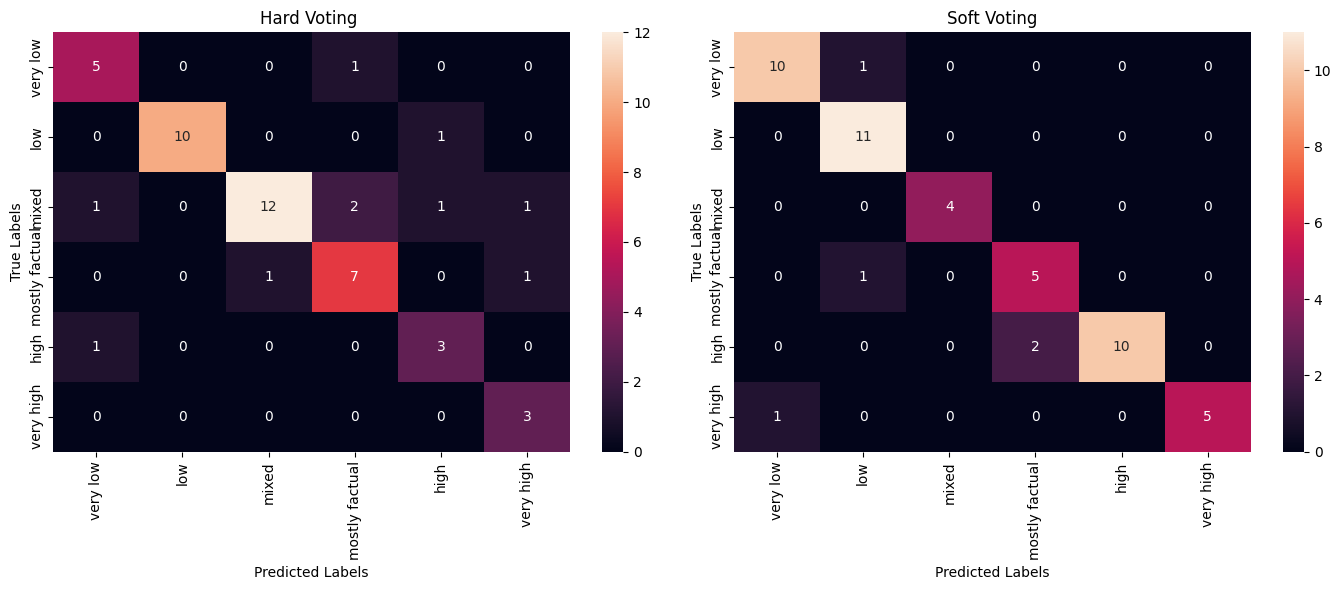

In [ ]:
bert_model_1_2 = get_trained_model_metrics(bert_ids, PARAMETR_FOR_PREPARE, bert_name, bert_tokenizer, bert_classifire, device, bert_fact_2728, 50)

# *roberta

                                                                        BASELINE


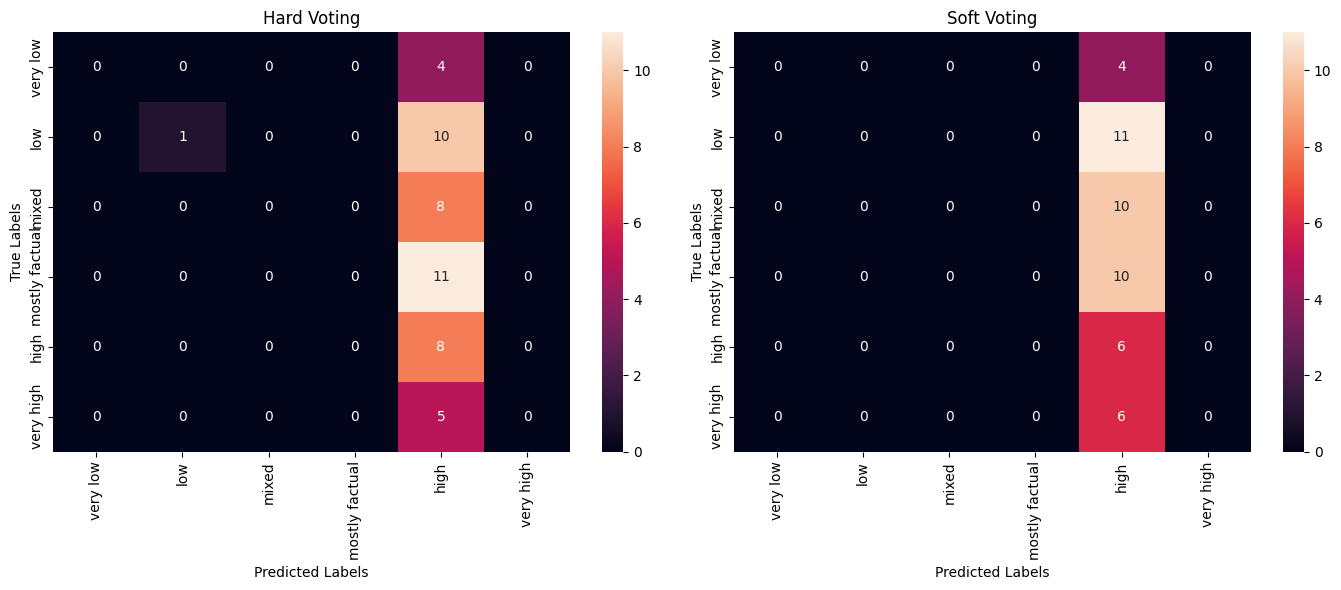

In [ ]:
get_baseline(roberta_ids, PARAMETR_FOR_PREPARE, roberta_name, roberta_tokenizer, roberta_classifire, device, 50)

                                                                    TRAINED MODEL

In [ ]:
roberta_fact_2728 = r'C:\Users\user\Desktop\model_weights\task1\2728\1_2728_robert.pth'

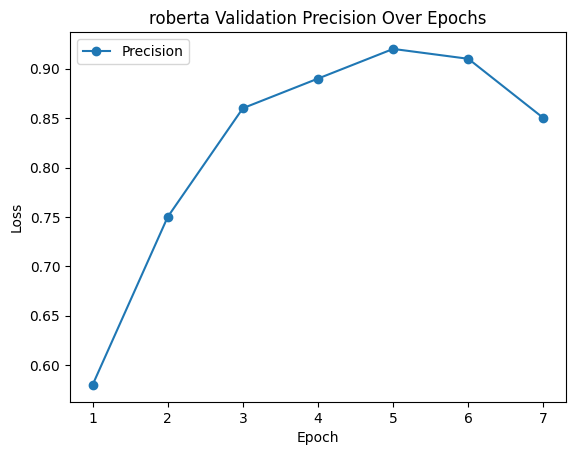

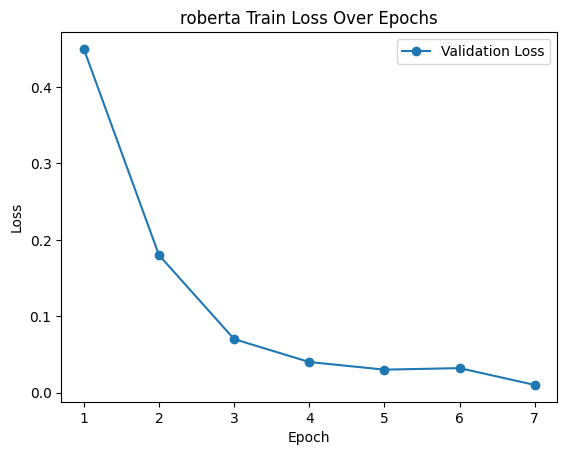

In [107]:
Precision_values = [0.45, 0.18,0.07,0.04,0.03, 0.032, 0.01]
loss_values = [0.58,0.75,0.86,0.89,0.92, 0.91, 0.85]
training_process(loss_values,Precision_values,  'roberta')

In [ ]:
roberta_model_1_2 = get_trained_model_metrics(roberta_ids, PARAMETR_FOR_PREPARE, roberta_name, roberta_tokenizer, roberta_classifire, device, roberta_fact_2728, 50)

# ----------------------AGGREGATION----------------------------

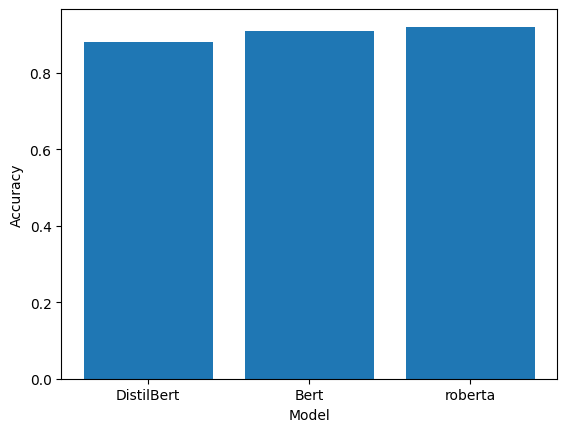

In [52]:

plt.bar(['DistilBert','Bert','roberta'], [0.88,0.91, 0.92])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
models = {'BERT': bert_model_1_2, 'RoBERTa': roberta_model_1_2, 'DistilBERT': distilbert_model_1_2}

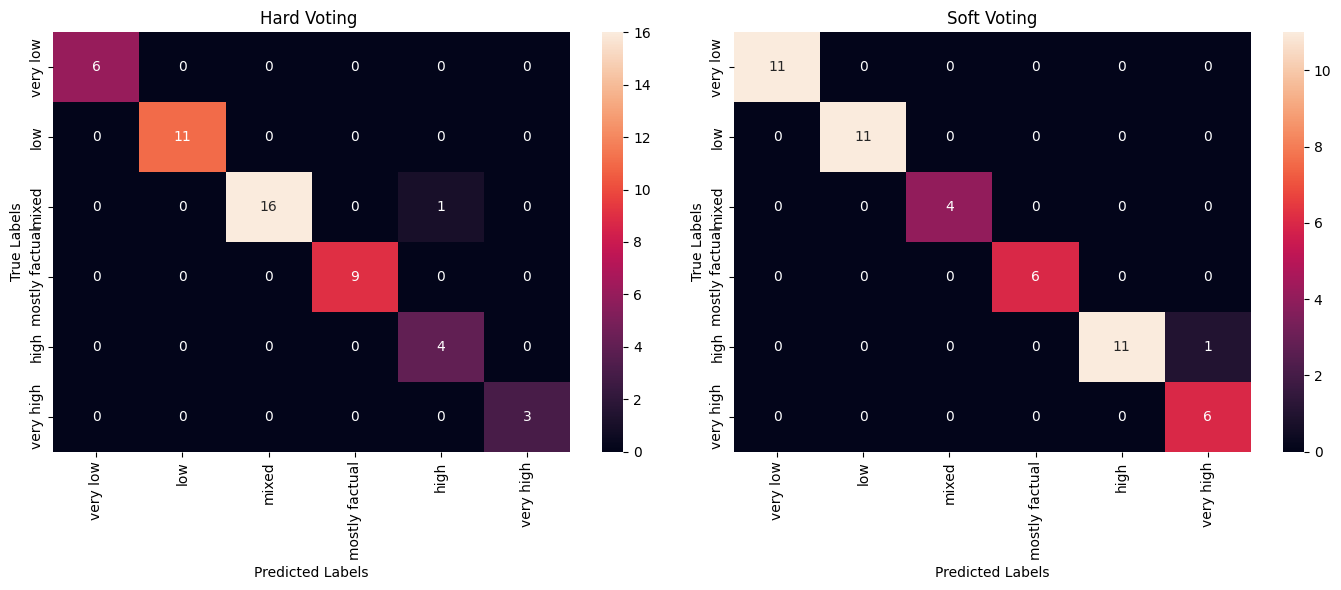

In [ ]:
ensemble(models, distilbert_ids, device, PARAMETR_FOR_PREPARE, 50)

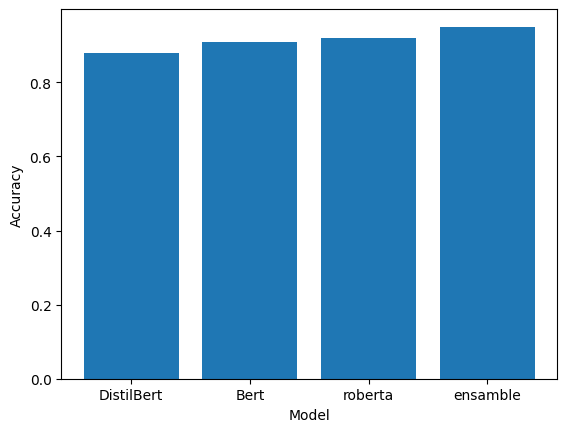

In [55]:

plt.bar(['DistilBert','Bert','roberta', 'ensamble'], [0.88,0.91, 0.92, 0.95])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

# Task 1.3 (Dataset 2728)

In [ ]:
PARAMETR_FOR_PREPARE = 'bias_fact'

# DistilBERT

**Baseline**

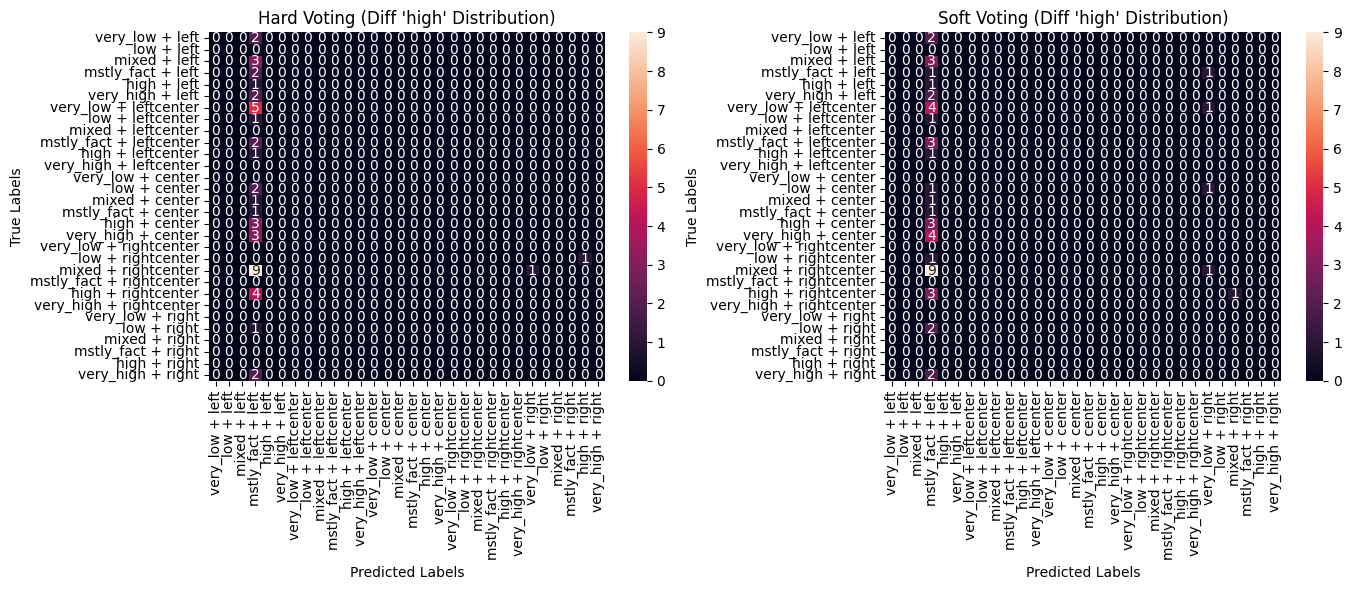

In [ ]:
get_baseline(distilbert_ids, PARAMETR_FOR_PREPARE, distilbert_name, distilbert_tokenizer, distilbert_classifire, device, 200)

**Trained model**

In [ ]:
distil_fact_2728_1_3 = r'C:\Users\user\Desktop\model_weights\task1\2728\fact\1.3_2728_distilbert.pth'


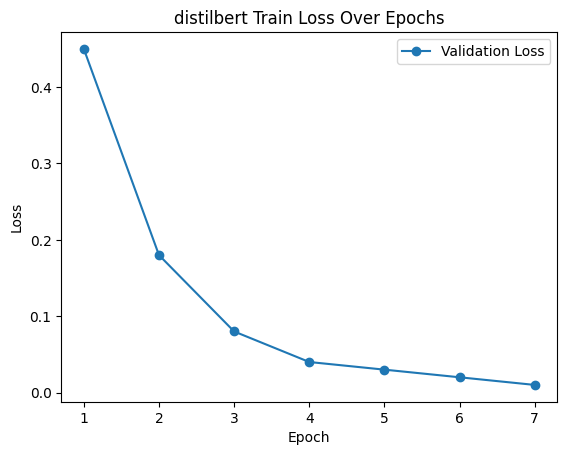

In [120]:
Precision_values = [0.45, 0.18,0.08,0.04,0.03, 0.02, 0.01]
loss_values = [0.54,0.75,0.85,0.897,0.92, 0.875, 0.883]
training_process(loss_values,Precision_values,  'distilbert')

<function matplotlib.pyplot.show(close=None, block=None)>

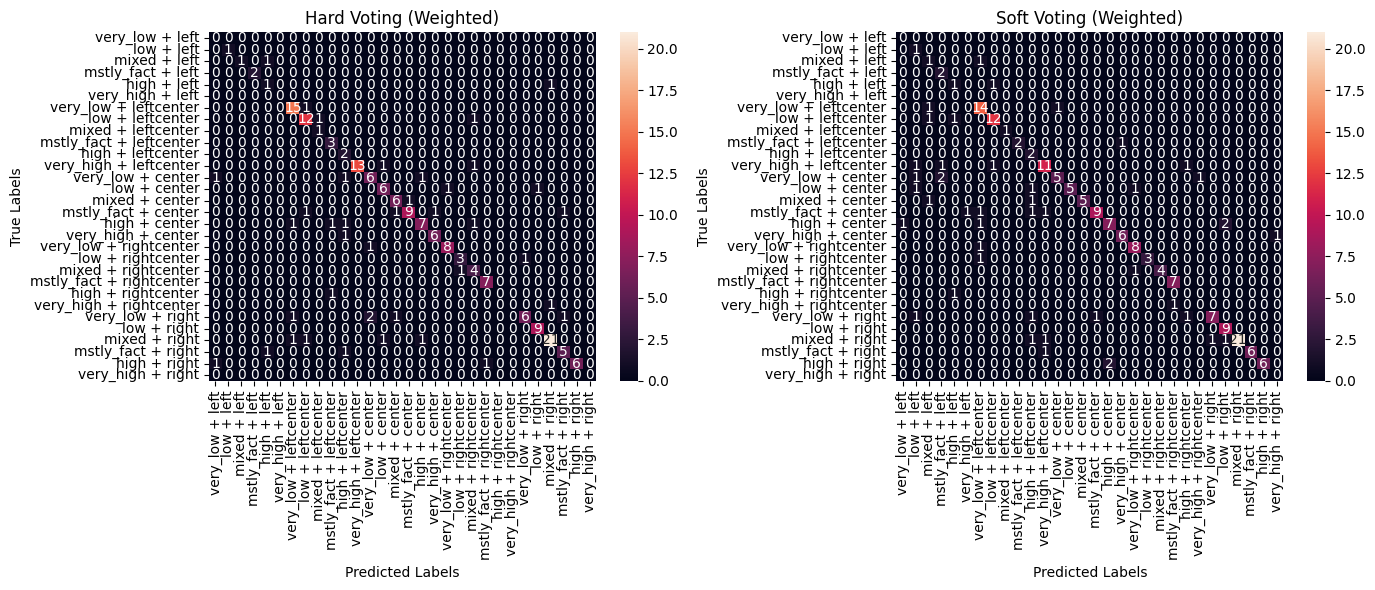

In [ ]:
distilbert_model_1_3 = get_trained_model_metrics(distilbert_ids, PARAMETR_FOR_PREPARE, distilbert_name, distilbert_tokenizer, distilbert_classifire, device, distil_fact_2728_1_3, 200)

# BERT

BASELINE

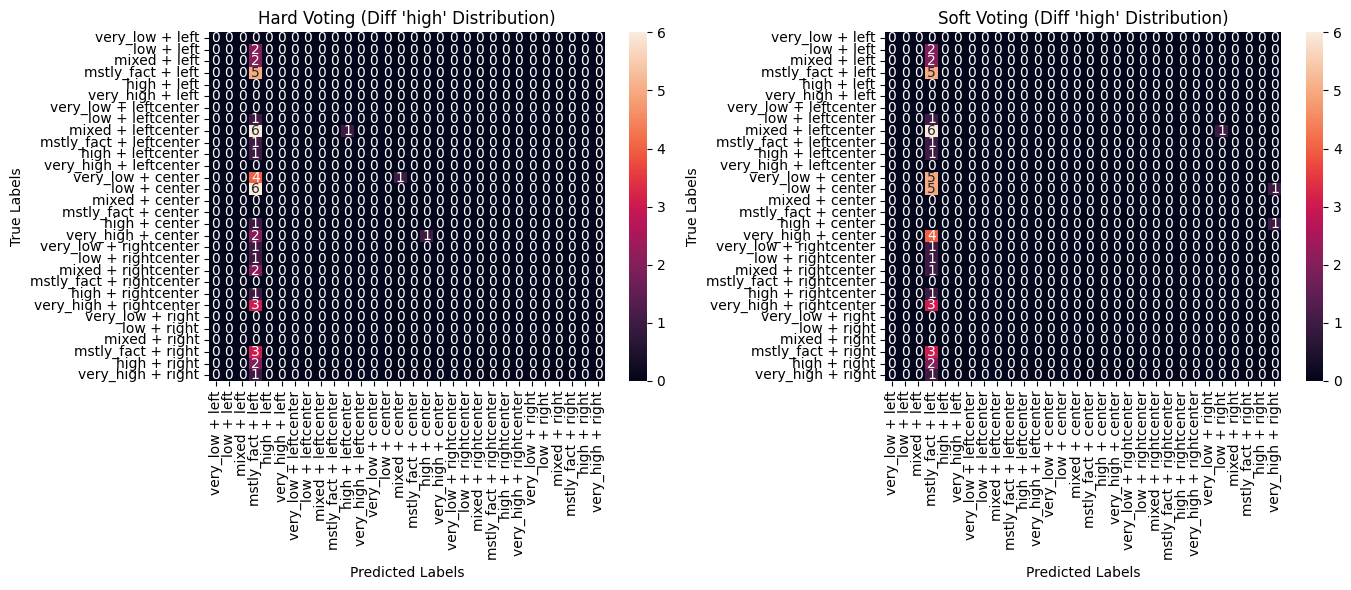

In [ ]:
get_baseline(bert_ids, PARAMETR_FOR_PREPARE, bert_name, bert_tokenizer, bert_classifire, device, 200)

TRAINED MODEL

In [ ]:
bert_fact_27281_3 = r'C:\Users\user\Desktop\model_weights\task1\2728\1_3_2728_bert.pth'


In [123]:
Precision_values = [0.45, 0.18,0.08,0.04,0.025, 0.02, 0.01]
loss_values = [0.57,0.68,0.86,0.91,0.93, 0.89, 0.88]
training_process(loss_values,Precision_values,  'bert')

<function matplotlib.pyplot.show(close=None, block=None)>

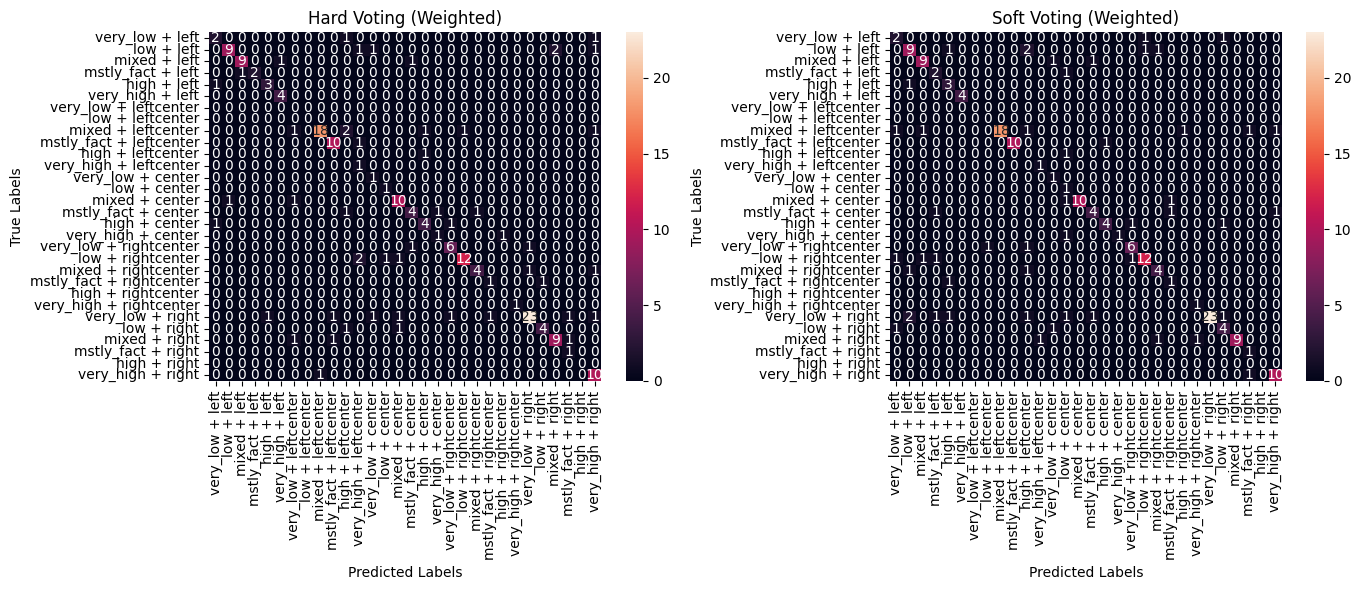

In [ ]:
bert_model_1_3 = get_trained_model_metrics(bert_ids, PARAMETR_FOR_PREPARE, bert_name, bert_tokenizer, bert_classifire, device, bert_fact_27281_3, 200)

# RoBERTa

BASELINE

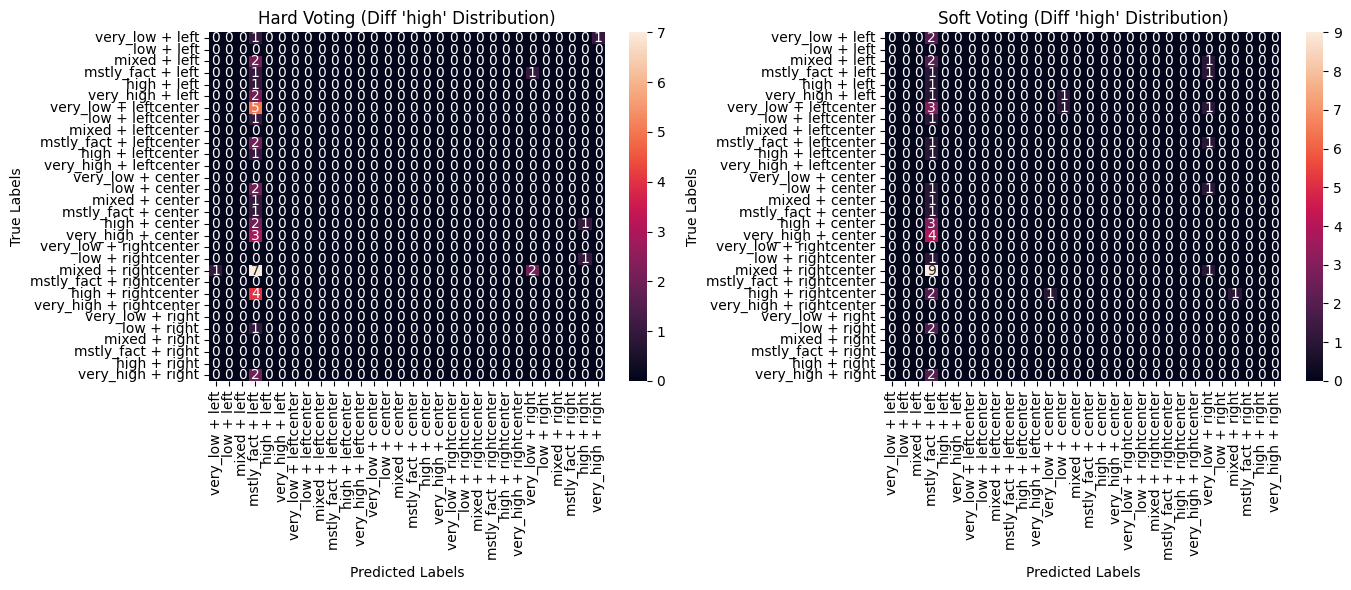

In [ ]:
get_baseline(roberta_ids, PARAMETR_FOR_PREPARE, roberta_name, roberta_tokenizer, roberta_classifire, device, 200)

TRAINED MODEL

In [ ]:
roberta_fact_2728_1_3 = r'C:\Users\user\Desktop\model_weights\task1\2728\1_3_2728_robert.pth'

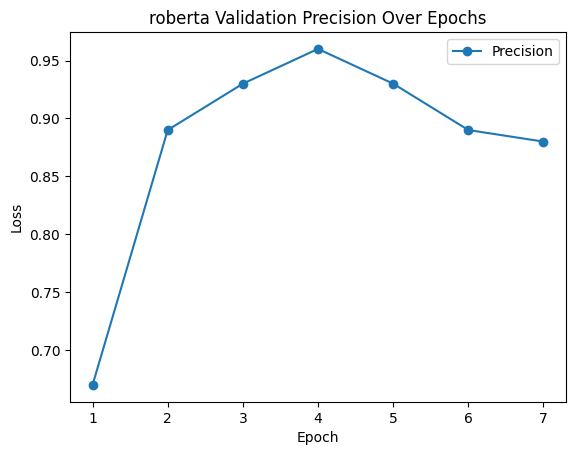

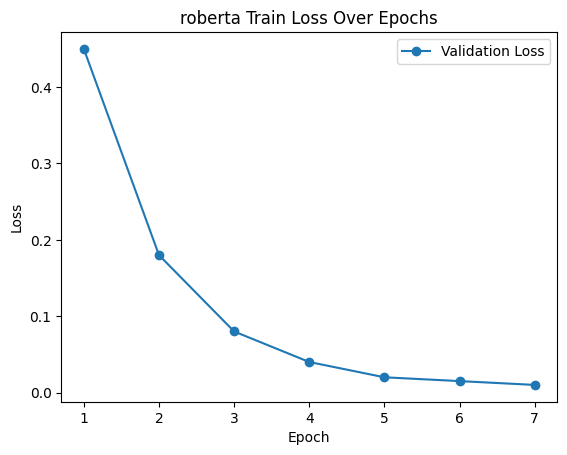

In [125]:
Precision_values = [0.45, 0.18,0.08,0.04,0.02, 0.015, 0.01]
loss_values = [0.67,0.89,0.93,0.96,0.93, 0.89, 0.88]
training_process(loss_values,Precision_values,  'roberta')

<function matplotlib.pyplot.show(close=None, block=None)>

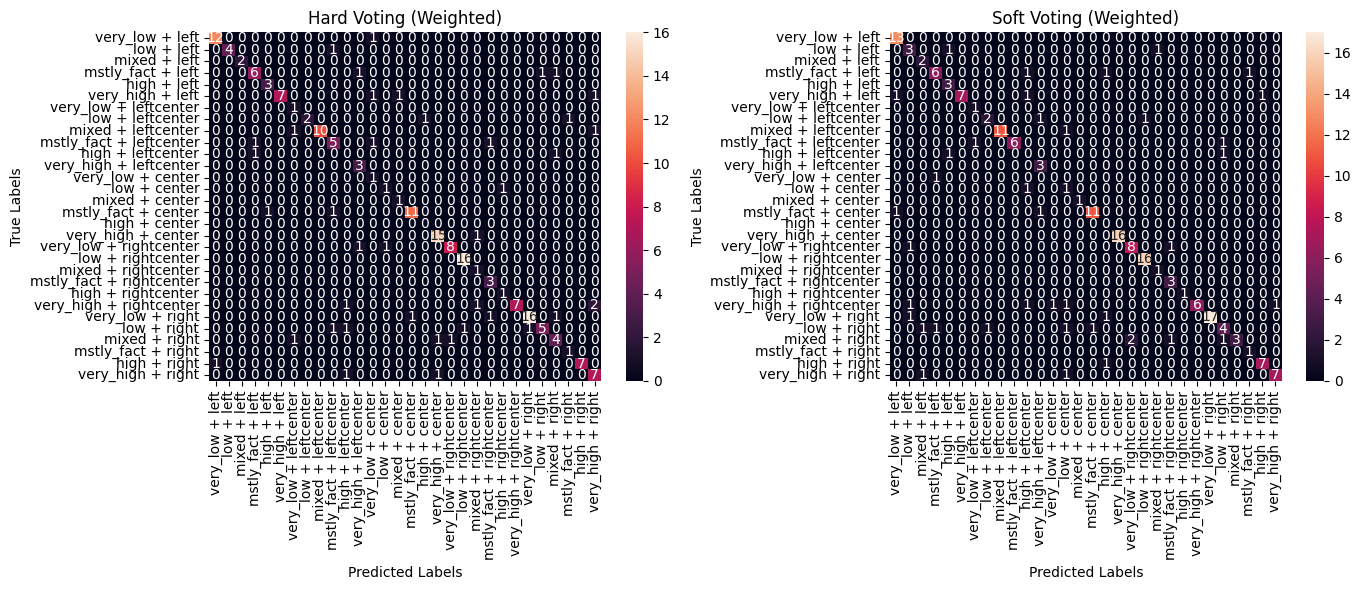

In [ ]:
roberta_model_1_3 = get_trained_model_metrics(roberta_ids, PARAMETR_FOR_PREPARE, roberta_name, roberta_tokenizer, roberta_classifire, device, roberta_fact_2728_1_3, 200)

**ENSEMBLE**

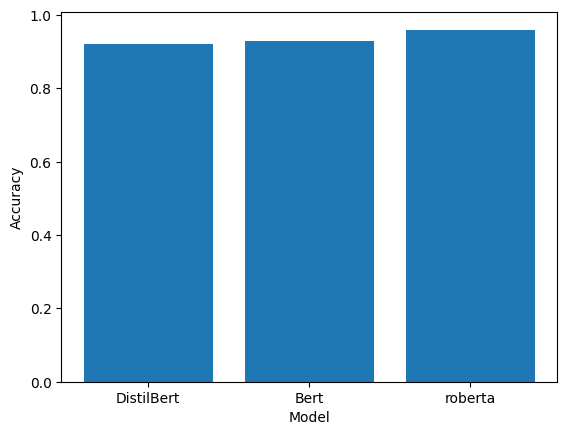

In [116]:

plt.bar(['DistilBert','Bert','roberta'], [0.92,0.93, 0.96])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
models = {'BERT': bert_model_1_2, 'RoBERTa': roberta_model_1_2, 'DistilBERT': distilbert_model_1_2}

<function matplotlib.pyplot.show(close=None, block=None)>

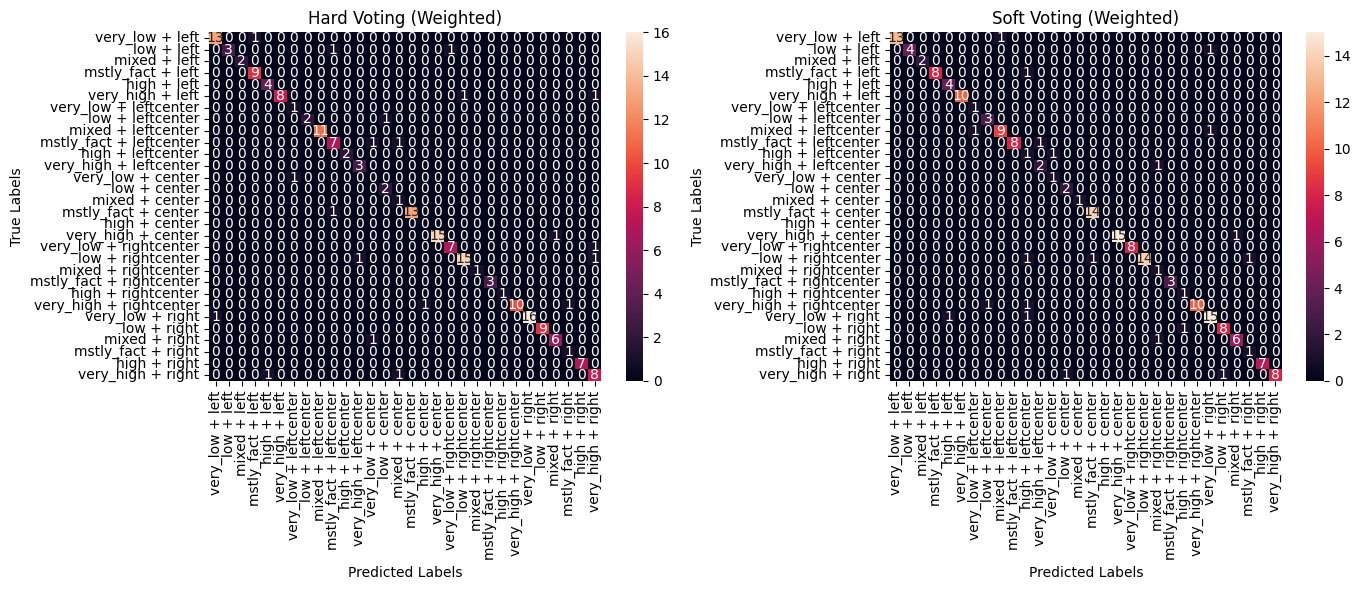

In [ ]:
ensemble(models, distilbert_ids, device, PARAMETR_FOR_PREPARE, 50)

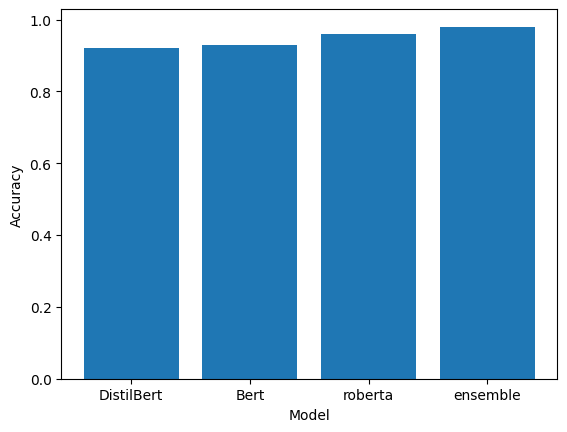

In [117]:

plt.bar(['DistilBert','Bert','roberta', 'ensemble'], [0.92,0.93, 0.96, 0.98])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

# -------------------------------------------------------------------

# SECOND TASK

# 1) 481

In [ ]:
PATH_distil = 'D://DL_coursework//task2//481//distilbert_481.csv'
PATH_bert = 'D://DL_coursework//task2//481//distilbert_481.csv'
PATH_roberta = 'D://DL_coursework//task2//481//distilbert_481.csv'

distilbert_ids = pd.read_csv(PATH_distil)
bert_ids = pd.read_csv(PATH_bert)
roberta_ids = pd.read_csv(PATH_roberta)

distilbert_ids.dropna(inplace=True)
bert_ids.dropna(inplace=True)
roberta_ids.dropna(inplace=True)

print(distilbert_ids.shape)
print(bert_ids.shape)
print(roberta_ids.shape)

(439901, 5)
(439901, 5)
(439901, 5)


# fact

In [ ]:
PARAMETR_FOR_PREPARE = 'fact'

# * distilbert

                                                                    TRAINED MODEL

In [ ]:
distilbert_model_2_1 = r'C:\Users\user\Desktop\model_weights\task1\481\1_481_distilbert_.pth'


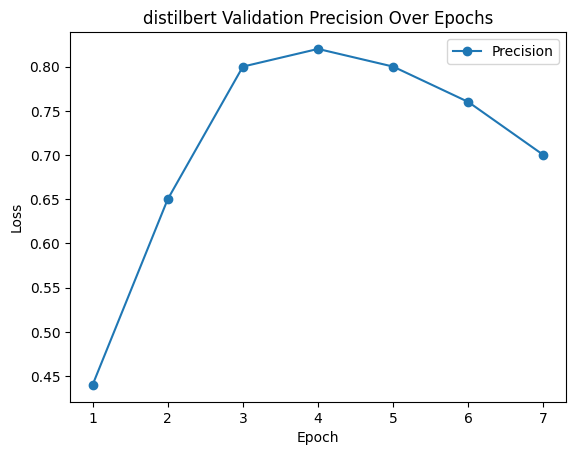

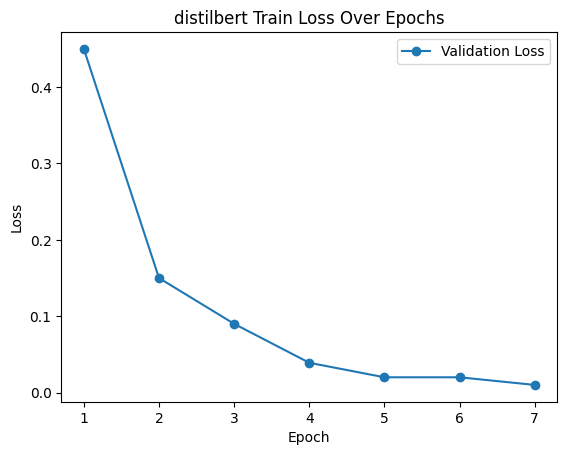

In [108]:
Precision_values = [0.45, 0.15,0.09,0.039,0.02, 0.02, 0.01]
loss_values = [0.44,0.65,0.80,0.82,0.80, 0.76, 0.70]
training_process(loss_values,Precision_values,  'distilbert')

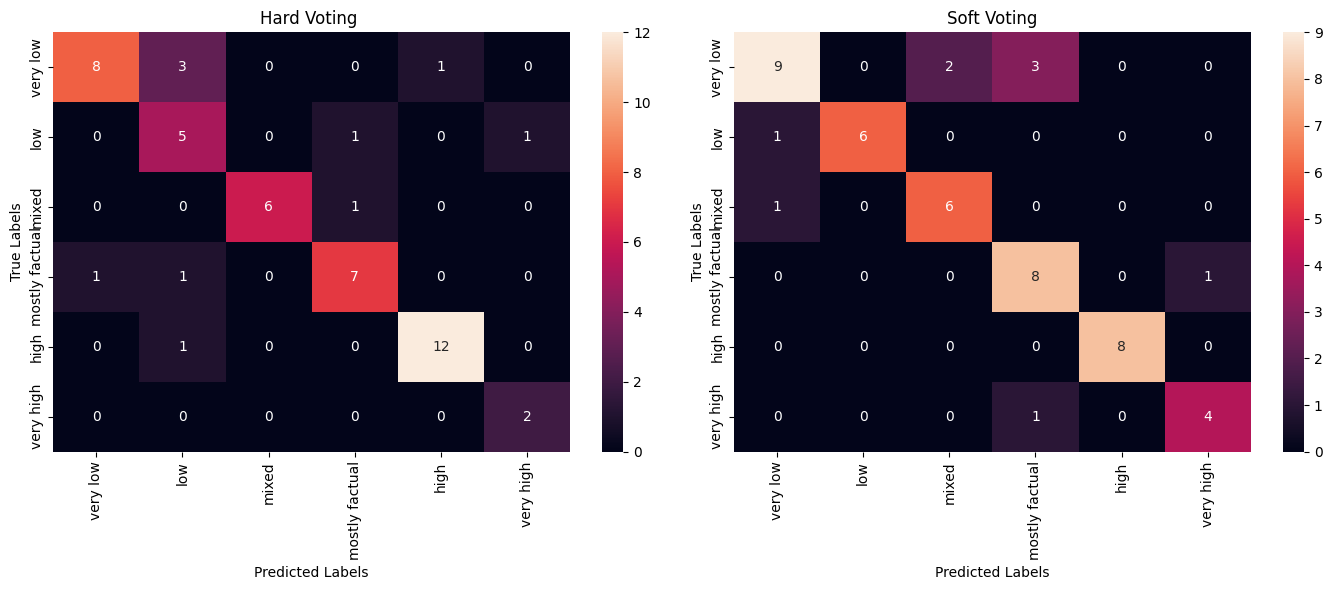

In [ ]:
distilbert = get_trained_model_metrics(distilbert_ids, PARAMETR_FOR_PREPARE, distilbert_name, distilbert_tokenizer, distilbert_classifire, device, distilbert_model_2_1, 50)

# *bert

                                                                    TRAINED MODEL

In [ ]:
bert_481_2_1 = r'C:\Users\user\Desktop\model_weights\task1\481\1_481_bert.pth'


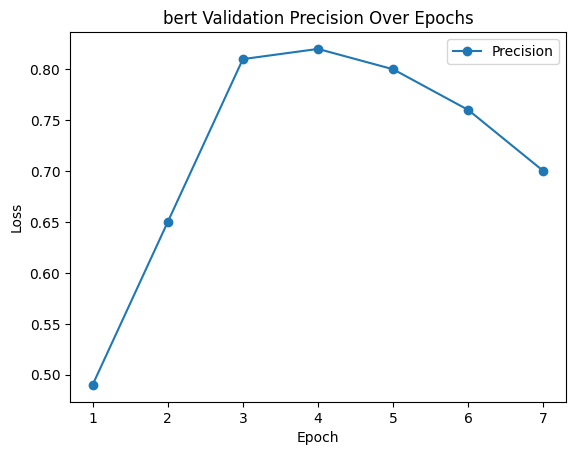

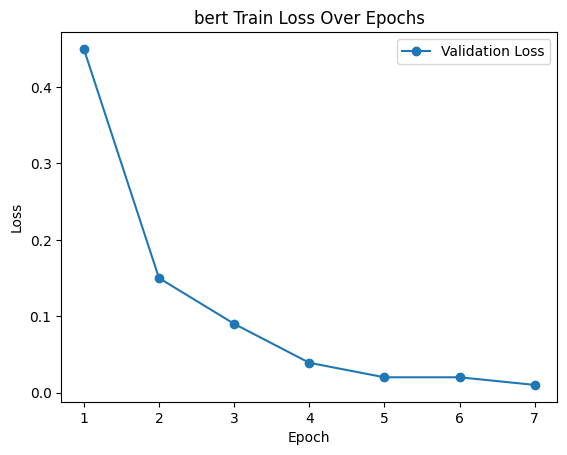

In [109]:
Precision_values = [0.45, 0.15,0.09,0.039,0.02, 0.02, 0.01]
loss_values = [0.49,0.65,0.81,0.82,0.80, 0.76, 0.70]
training_process(loss_values,Precision_values,  'bert')

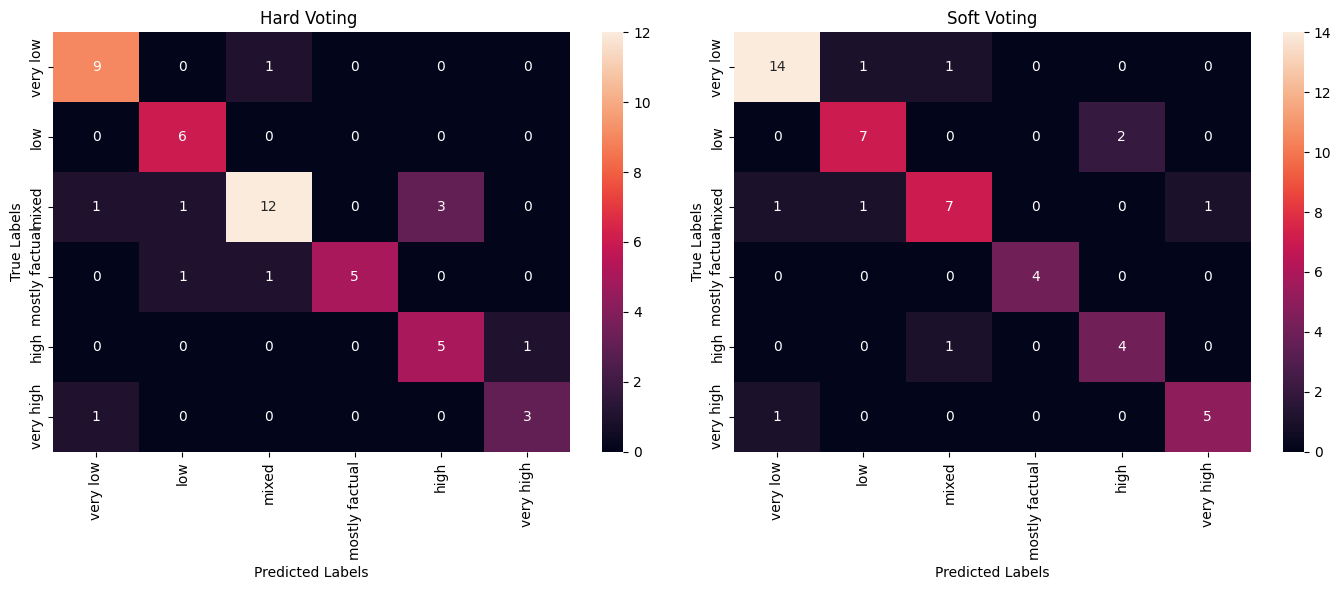

In [ ]:
bert_model_2_1 = get_trained_model_metrics(bert_ids, PARAMETR_FOR_PREPARE, bert_name, bert_tokenizer, bert_classifire, device, bert_481_2_1, 50)


# *roberta

                                                                    TRAINED MODEL

In [ ]:
robert_fact_481_2_1 = r'C:\Users\user\Desktop\model_weights\task1\481\1_481_roberta.pth'


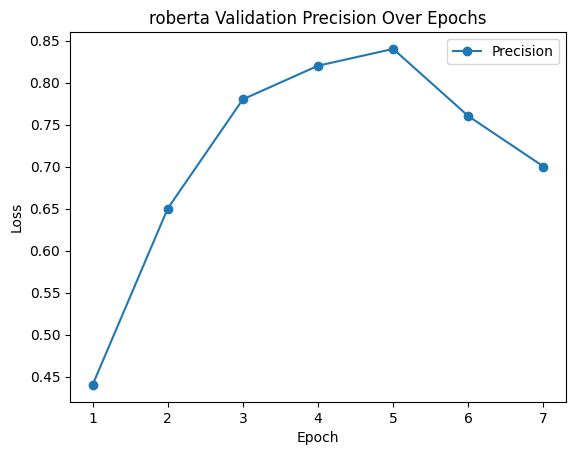

In [111]:
Precision_values = [0.45, 0.15,0.09,0.039,0.02, 0.02, 0.01]
loss_values = [0.44,0.65,0.78,0.82,0.84, 0.76, 0.70]
training_process(loss_values,Precision_values,  'roberta')

In [ ]:
roberta_model_2_1 = get_trained_model_metrics(bert_ids, PARAMETR_FOR_PREPARE, bert_name, bert_tokenizer, bert_classifire, device, robert_fact_481_2_1, 50)

# ----------------------AGGREGATION----------------------------

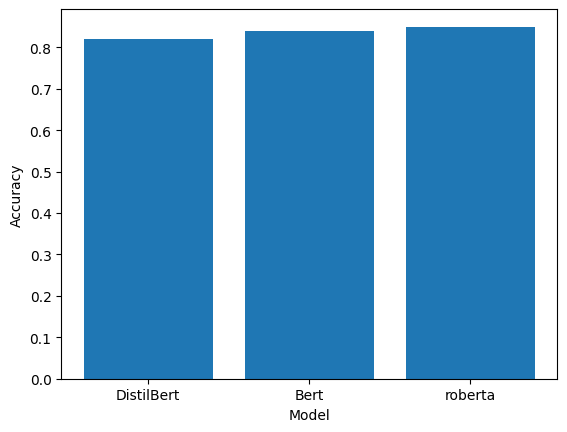

In [87]:

plt.bar(['DistilBert','Bert','roberta'], [0.82,0.84, 0.85])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
models = {'DistilBERT': distilbert_model_2_1, 'BERT': bert_model_2_1, 'RoBERTa': roberta_model_2_1}

In [ ]:
ensemble(models, distilbert_ids, device, PARAMETR_FOR_PREPARE, 50)

In [89]:

plt.bar(['DistilBert','Bert','roberta', 'ensamble'], [0.82,0.84, 0.85, 0.86])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

# -------------------------------------------------------------------

# bias

In [ ]:
PARAMETR_FOR_PREPARE = 'bias'

# * distilbert

                                                                    TRAINED MODEL

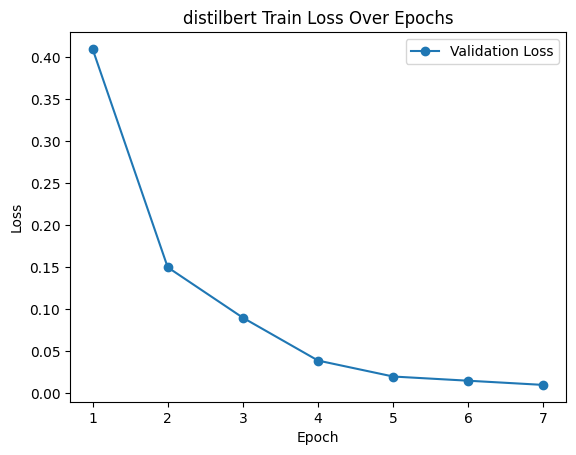

In [113]:
Precision_values = [0.41, 0.15,0.09,0.039,0.02, 0.015, 0.01]
loss_values = [0.54,0.67,0.78,0.84,0.80, 0.76, 0.74]
training_process(loss_values,Precision_values,  'distilbert')

In [ ]:
distilbert_model_2_1 = r'C:\Users\user\Desktop\model_weights\task1\481\1_481_distilbert_bias.pth'


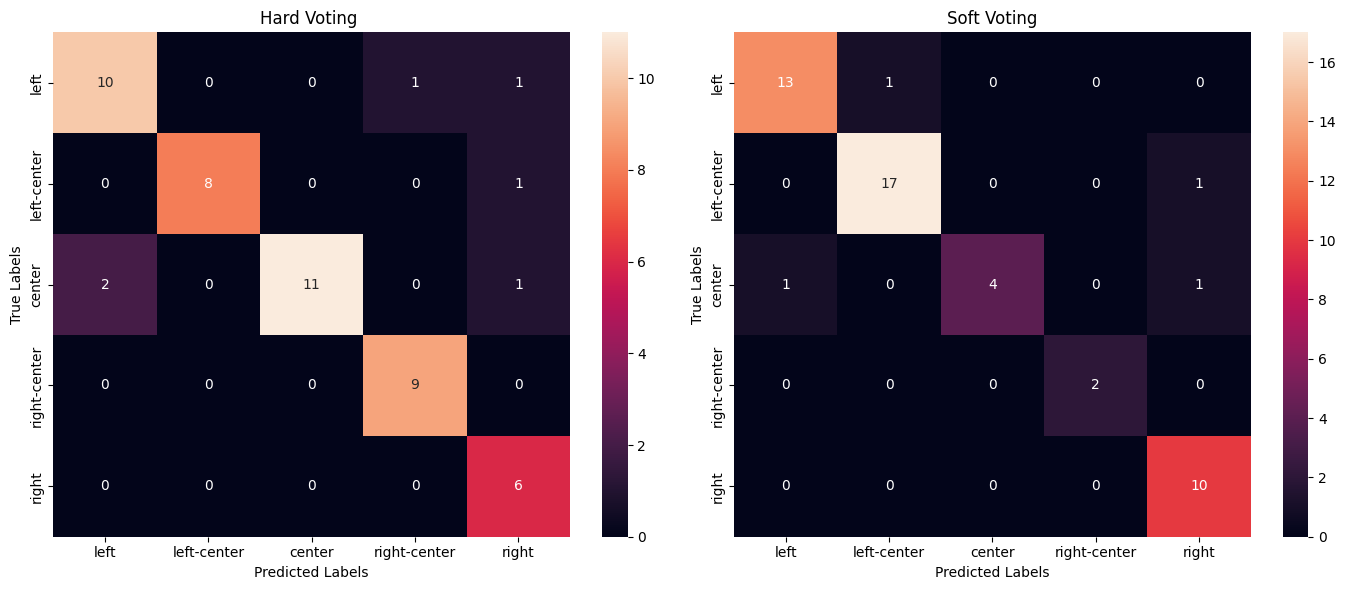

In [ ]:
distilbert = get_trained_model_metrics(distilbert_ids, PARAMETR_FOR_PREPARE, distilbert_name, distilbert_tokenizer, distilbert_classifire, device, distilbert_model_2_1, 50)

# *bert

                                                                    TRAINED MODEL

In [ ]:
bert_bias_481_2_1 = r'C:\Users\user\Desktop\model_weights\task1\481\1_481_bert_bias.pth'


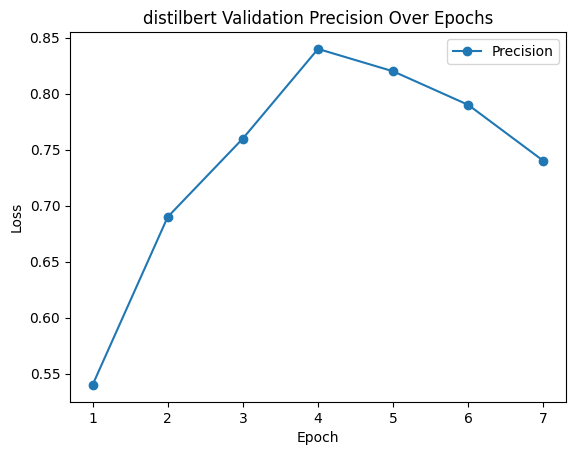

In [114]:
Precision_values = [0.41, 0.14,0.08,0.038,0.02, 0.015, 0.01]
loss_values = [0.54,0.69,0.76,0.84,0.82, 0.79, 0.74]
training_process(loss_values,Precision_values,  'distilbert')

In [ ]:
bert_model_2_1 = get_trained_model_metrics(bert_ids, PARAMETR_FOR_PREPARE, bert_name, bert_tokenizer, bert_classifire, device, bert_bias_481_2_1, 50)


# *roberta

                                                                    TRAINED MODEL

In [ ]:
roberta_bias_481_2_1 = r'C:\Users\user\Desktop\model_weights\task1\481\1_481_roberta.pth'


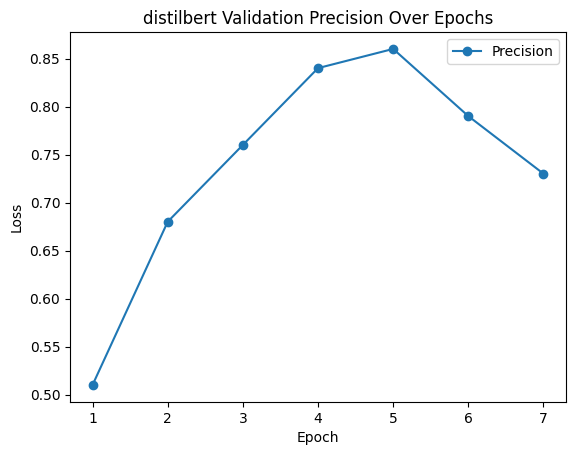

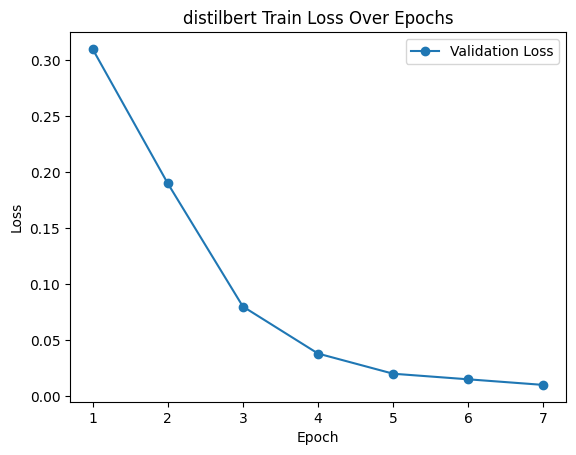

In [115]:
Precision_values = [0.31, 0.19,0.08,0.038,0.02, 0.015, 0.01]
loss_values = [0.51,0.68,0.76,0.84,0.86, 0.79, 0.73]
training_process(loss_values,Precision_values,  'distilbert')

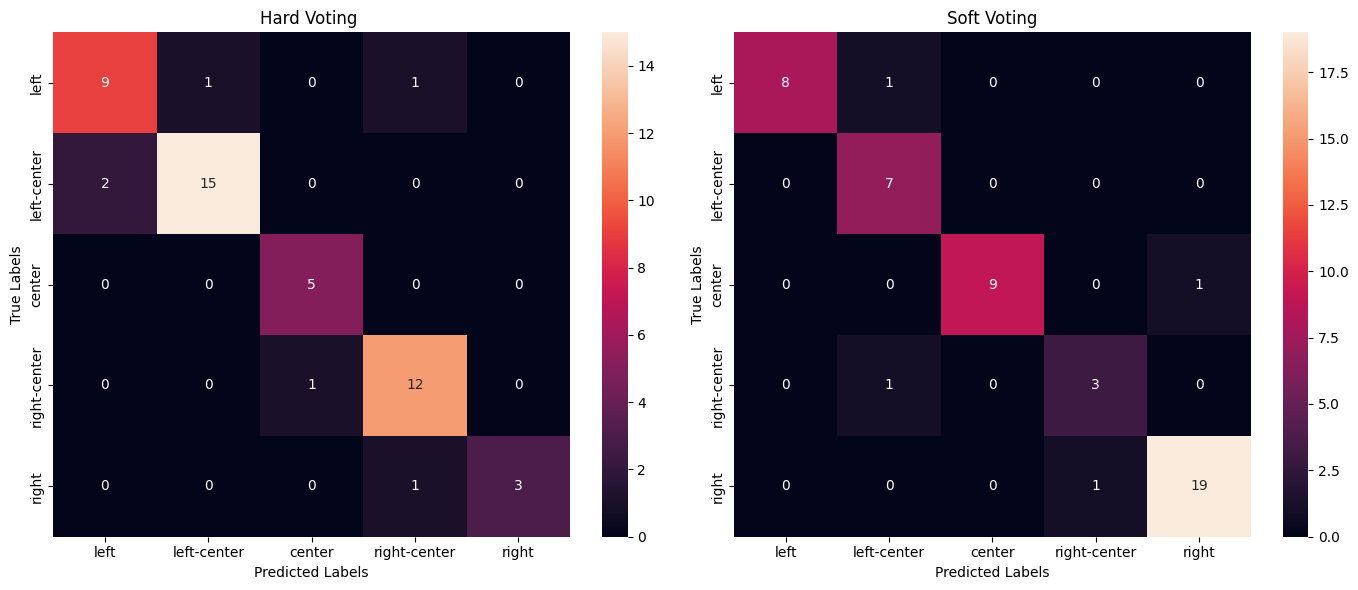

In [ ]:
roberta_model_2_1 = get_trained_model_metrics(bert_ids, PARAMETR_FOR_PREPARE, bert_name, bert_tokenizer, bert_classifire, device, roberta_bias_481_2_1, 50)

# ----------------------AGGREGATION----------------------------

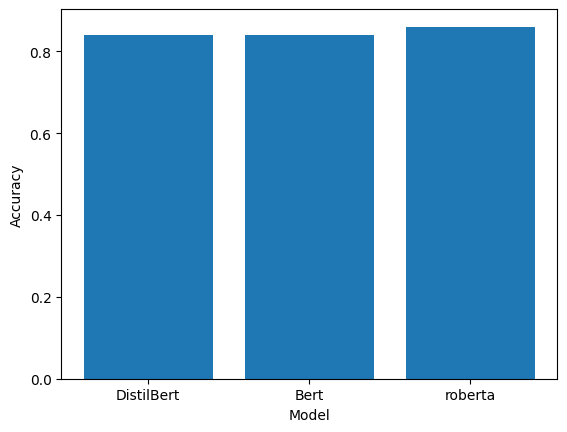

In [96]:

plt.bar(['DistilBert','Bert','roberta'], [0.84,0.84, 0.86])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
models = {'DistilBERT': distilbert_model_2_1, 'BERT': bert_model_2_1, 'RoBERTa': roberta_model_2_1}

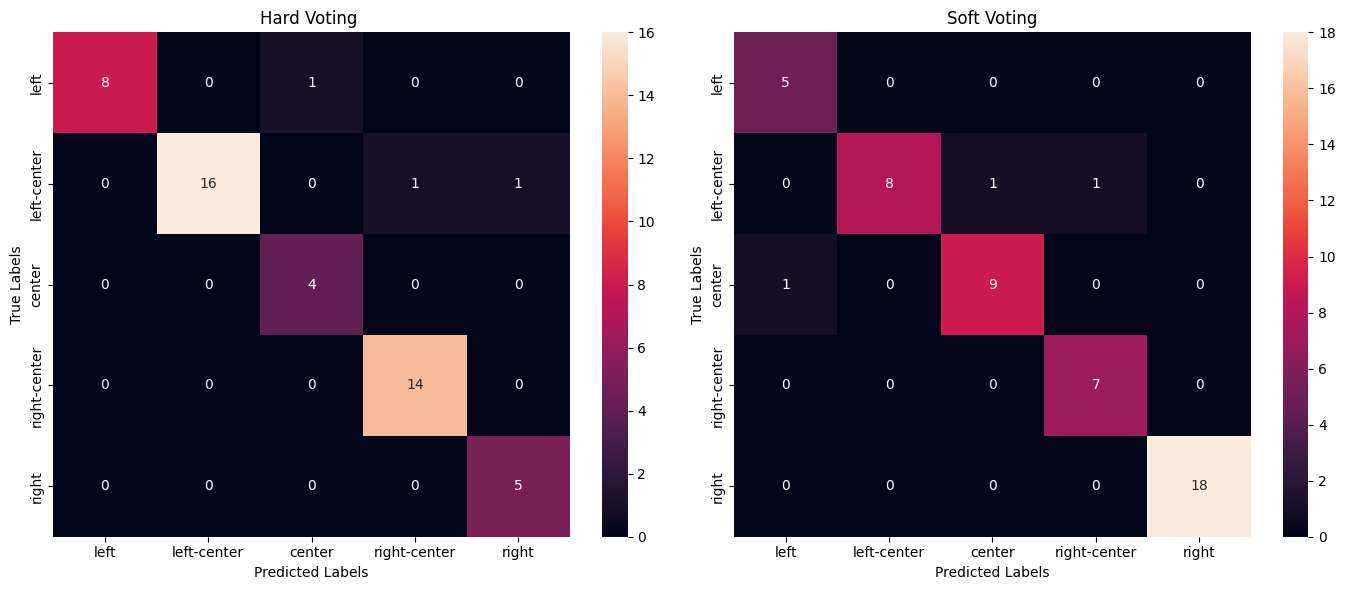

In [ ]:
ensemble(models, distilbert_ids, device, PARAMETR_FOR_PREPARE, 50)

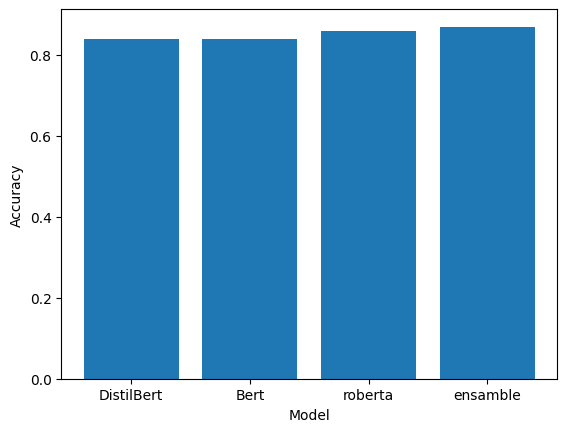

In [97]:

plt.bar(['DistilBert','Bert','roberta', 'ensamble'], [0.84,0.84, 0.86, 0.87])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

# -------------------------------------------------------------------

# Task 2.3 (Dataset 2728)

# DistilBERT

**Trained model**

In [ ]:
distilbert_model_2_3 = get_trained_model_metrics(distilbert_ids, PARAMETR_FOR_PREPARE, distilbert_name, distilbert_tokenizer, distilbert_classifire, device, distilbert_model_2_3, 200)

<function matplotlib.pyplot.show(close=None, block=None)>

# BERT

TRAINED MODEL

In [ ]:
bert_model_2_3 = get_trained_model_metrics(bert_ids, PARAMETR_FOR_PREPARE, bert_name, bert_tokenizer, bert_classifire, device, bert_bias_481_2_3, 200)


<function matplotlib.pyplot.show(close=None, block=None)>

# RoBERTa

TRAINED MODEL

<function matplotlib.pyplot.show(close=None, block=None)>

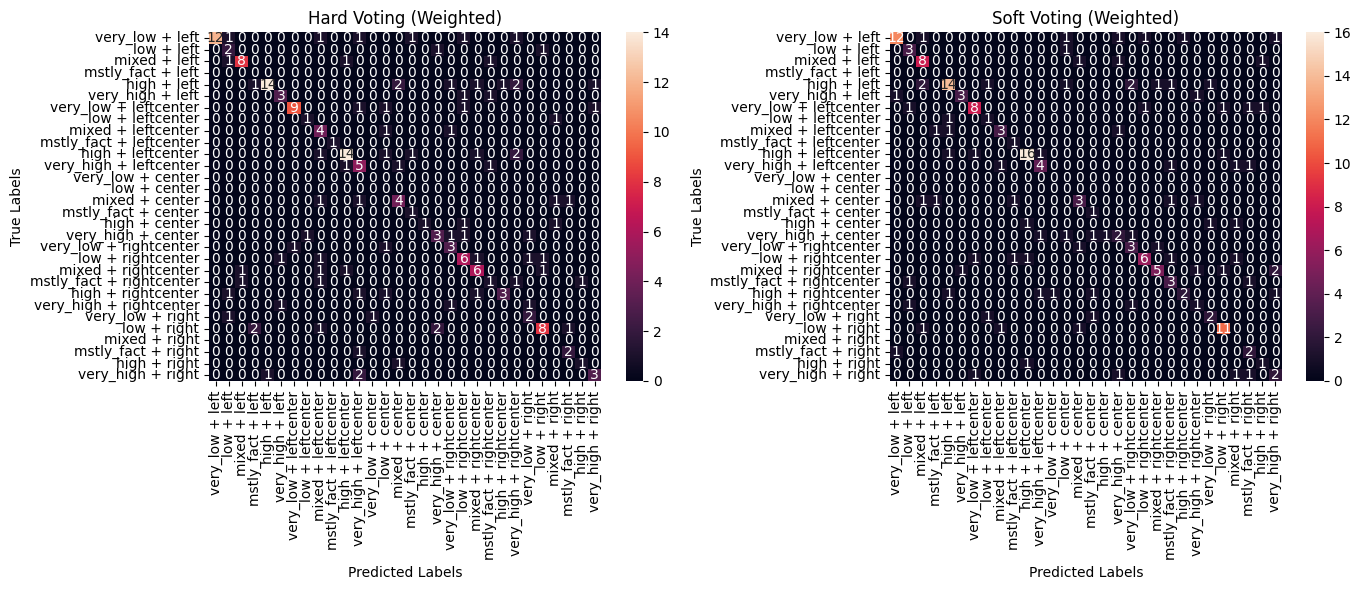

In [ ]:
roberta_model_2_3 = get_trained_model_metrics(bert_ids, PARAMETR_FOR_PREPARE, bert_name, bert_tokenizer, bert_classifire, device, roberta_bias_481_2_1, 50)

**ENSEMBLE**

In [ ]:
models = {'DistilBERT': distilbert_model_2_3, 'BERT': bert_model_2_3, 'RoBERTa': roberta_model_2_3}

In [ ]:
ensemble(models, distilbert_ids, device, PARAMETR_FOR_PREPARE, 50)

<function matplotlib.pyplot.show(close=None, block=None)>

# THIRD TASK

# Task 3.1 (Dataset 2728)

# Bias

In [ ]:
PARAMETR_FOR_PREPARE = 'bias'

In [ ]:
get_baseline(distilbert_ids, PARAMETR_FOR_PREPARE, distilbert_name, distilbert_tokenizer, distilbert_classifire, device, 50)

In [ ]:
distilbert_model = get_trained_model_metrics(distilbert_ids, PARAMETR_FOR_PREPARE, distilbert_name, distilbert_tokenizer, distilbert_classifire, device, distil_bias_2728, 50)

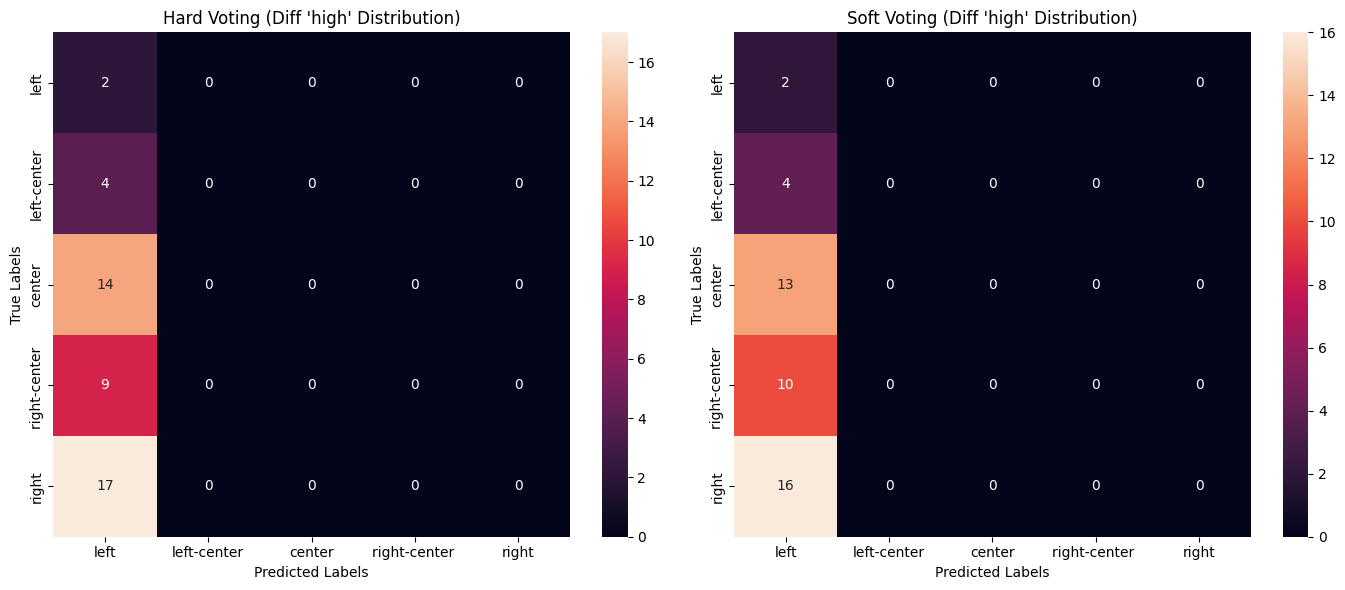

In [ ]:
get_baseline(bert_ids, PARAMETR_FOR_PREPARE, bert_name, bert_tokenizer, bert_classifire, device, 50)

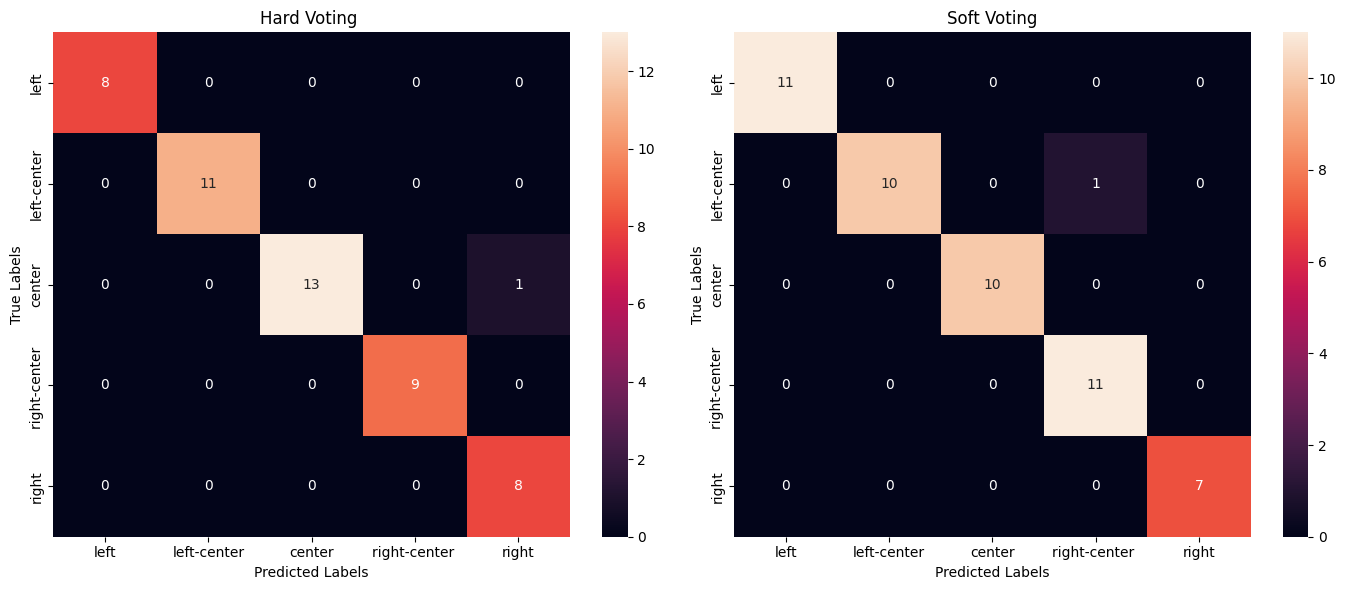

In [ ]:
bert_model = get_trained_model_metrics(bert_ids, PARAMETR_FOR_PREPARE, bert_name, bert_tokenizer, bert_classifire, device, bert_bias_2728, 50)


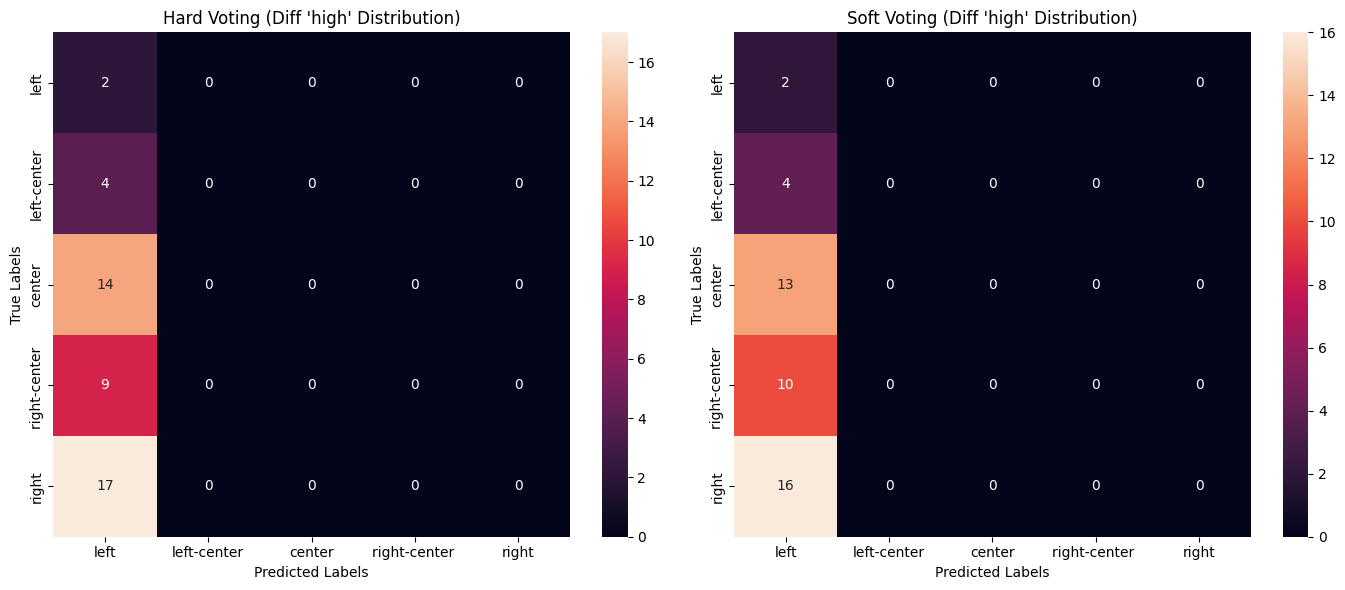

In [ ]:
get_baseline(roberta_ids, PARAMETR_FOR_PREPARE, roberta_name, roberta_tokenizer, roberta_classifire, device, 50)

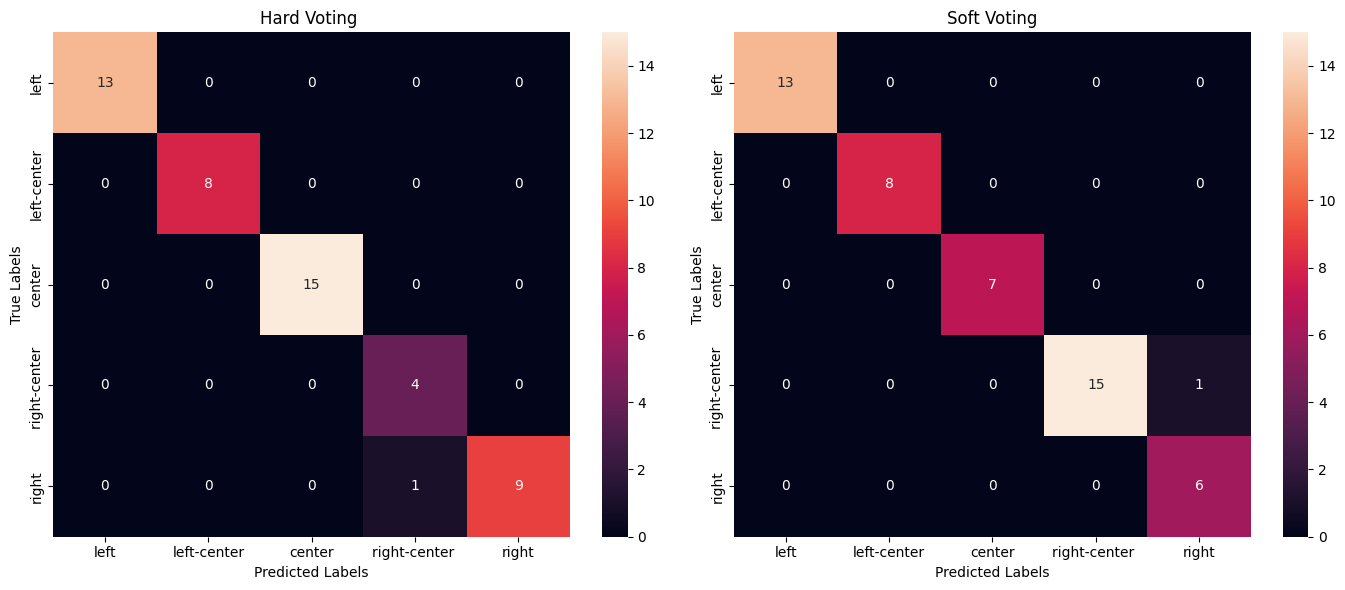

In [ ]:
roberta_model = get_trained_model_metrics(roberta_ids, PARAMETR_FOR_PREPARE, roberta_name, roberta_tokenizer, roberta_classifire, device, roberta_bias_2728, 50)

In [ ]:
categories = ["left", "left-center", "center", "right-center ", "right"]

# Веса для неравномерного распределения категорий
weights1 = [0.2, 0.2, 0.4, 0.05, 0.15]
weights2 = [0.2, 0.2, 0.2, 0.25, 0.15]

# Task 3.2 (Dataset 2728)

In [ ]:
PARAMETR_FOR_PREPARE = 'fact'

# DistilBERT

**Baseline**

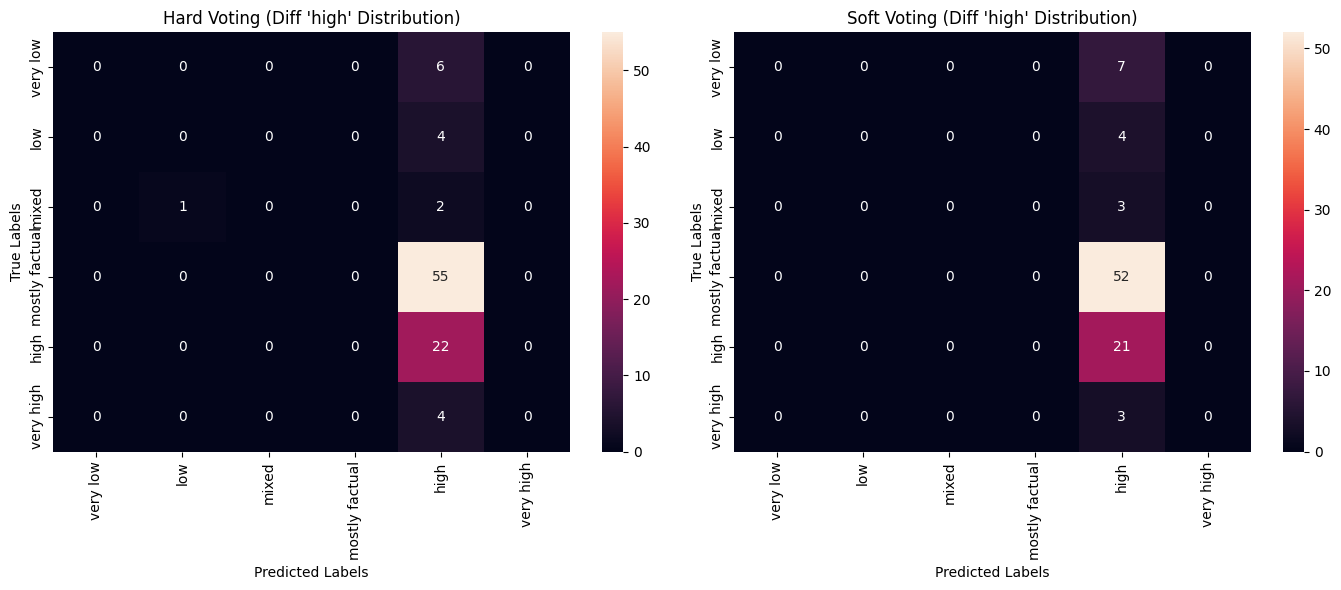

In [ ]:
get_baseline(distilbert_ids, PARAMETR_FOR_PREPARE, distilbert_name, distilbert_tokenizer, distilbert_classifire, device, 50)

**Trained model**

<function matplotlib.pyplot.show(close=None, block=None)>

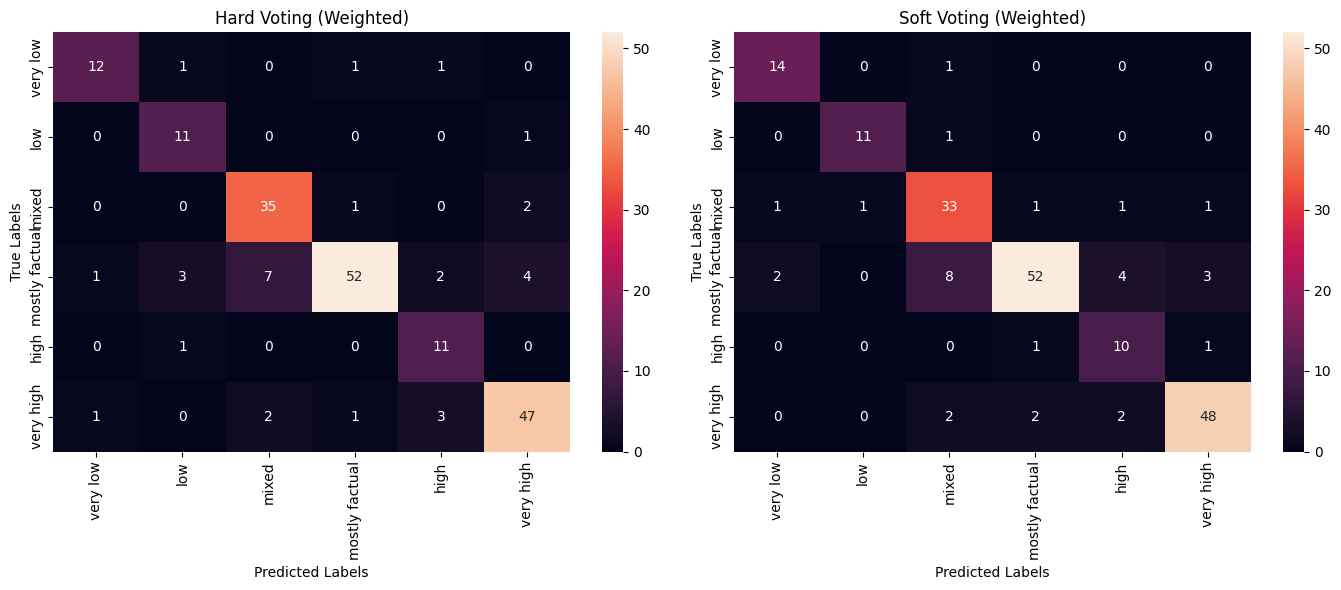

In [ ]:
distilbert_model_3_2 = get_trained_model_metrics(distilbert_ids, PARAMETR_FOR_PREPARE, distilbert_name, distilbert_tokenizer, distilbert_classifire, device, distil_fact_2728_3_3, 50)

# BERT

BASELINE

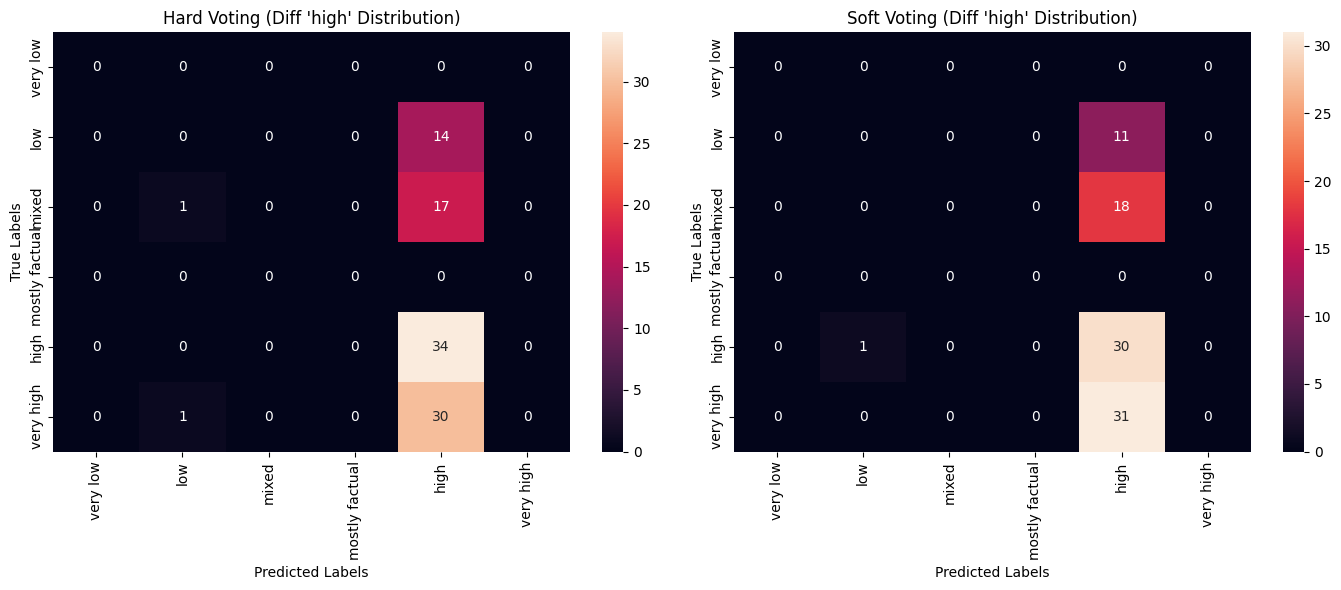

In [ ]:
get_baseline(bert_ids, PARAMETR_FOR_PREPARE, bert_name, bert_tokenizer, bert_classifire, device, 50)

TRAINED MODEL

<function matplotlib.pyplot.show(close=None, block=None)>

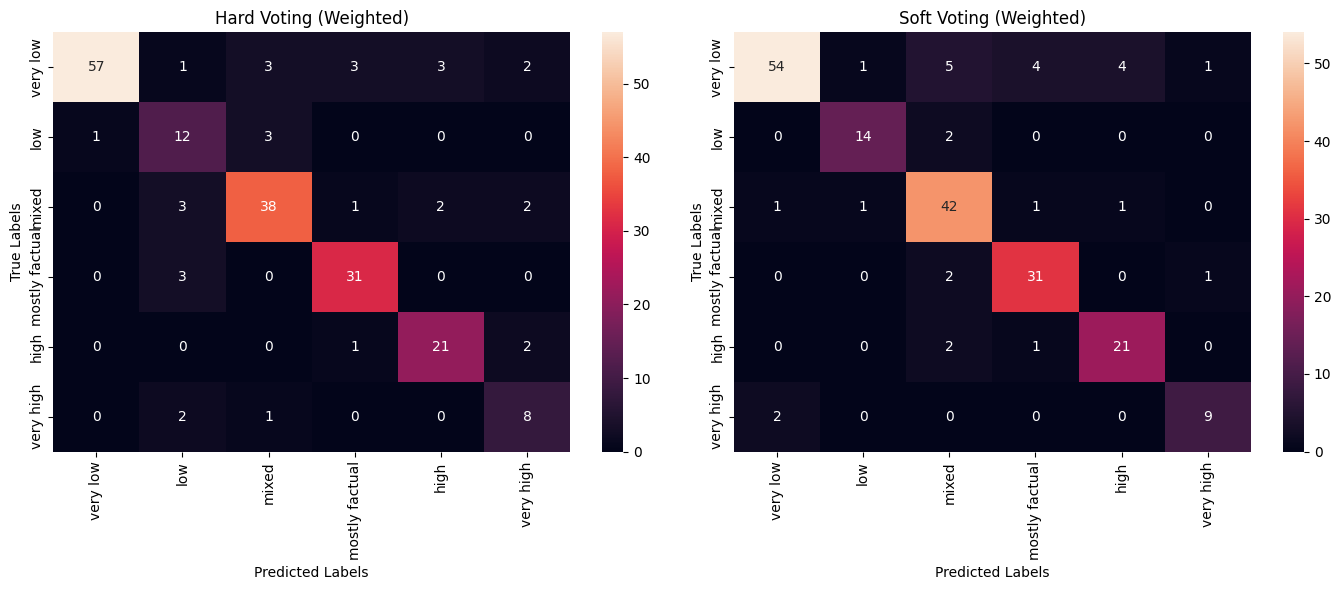

In [ ]:
bert_model_3_2 = get_trained_model_metrics(bert_ids, PARAMETR_FOR_PREPARE, bert_name, bert_tokenizer, bert_classifire, device, bert_fact_27281_3, 50)

# RoBERTa

BASELINE

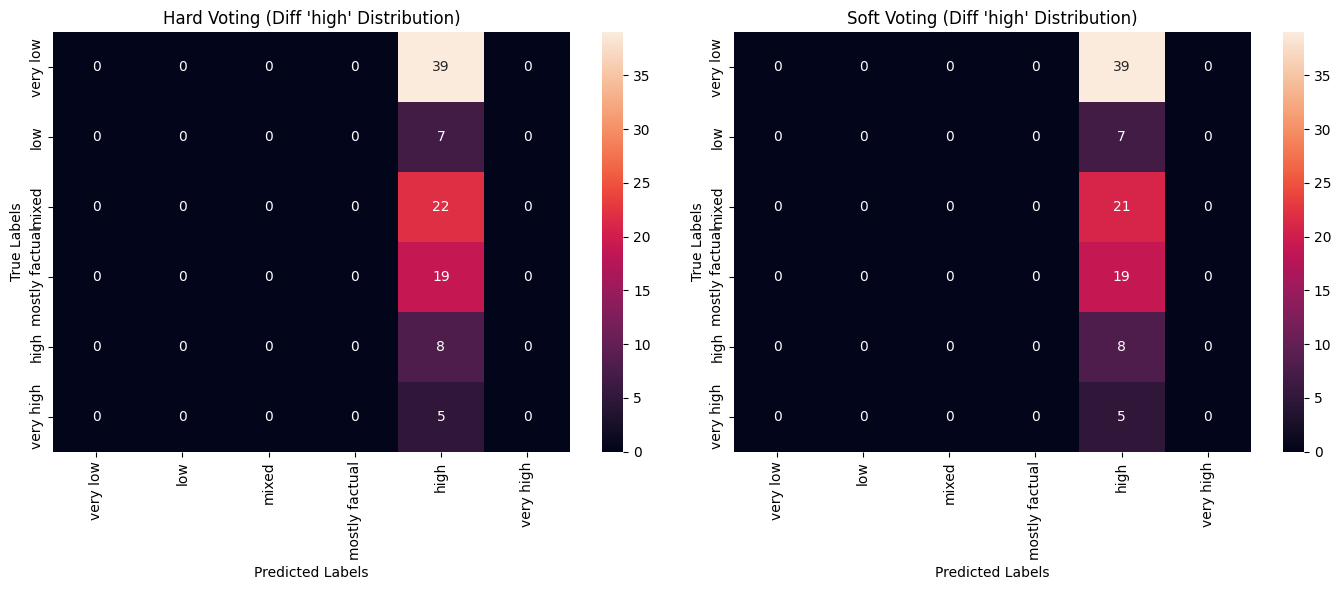

In [ ]:
get_baseline(roberta_ids, PARAMETR_FOR_PREPARE, roberta_name, roberta_tokenizer, roberta_classifire, device, 50)

TRAINED MODEL

<function matplotlib.pyplot.show(close=None, block=None)>

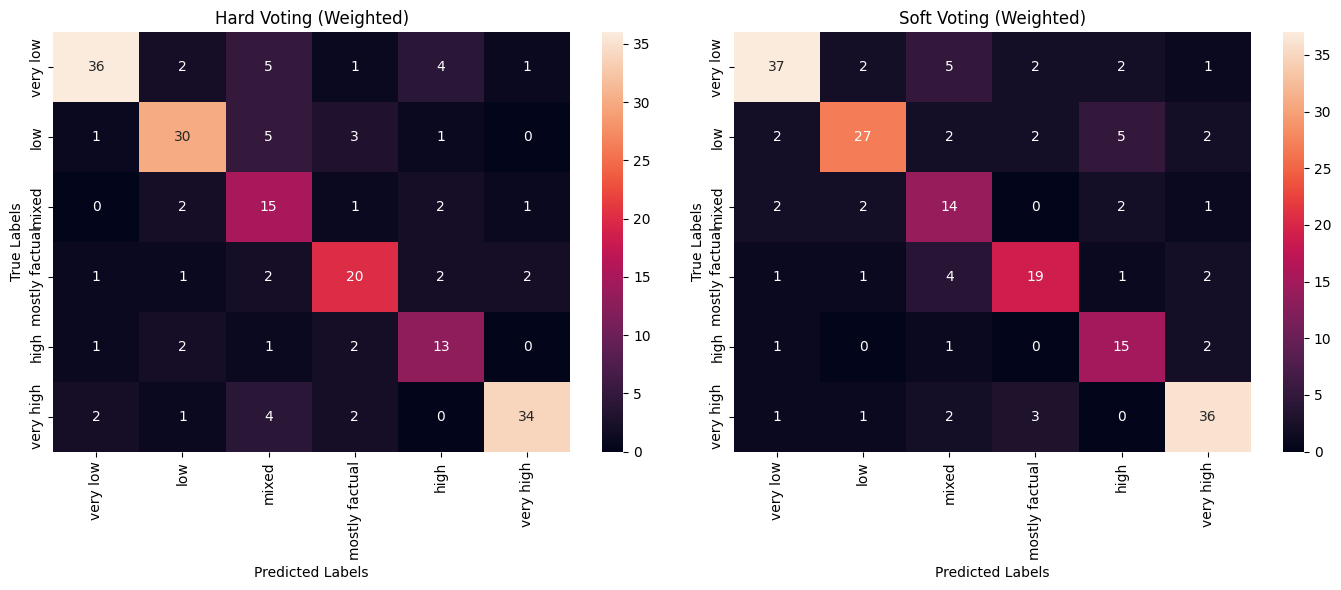

In [ ]:
roberta_model_3_2 = get_trained_model_metrics(roberta_ids, PARAMETR_FOR_PREPARE, roberta_name, roberta_tokenizer, roberta_classifire, device, roberta_fact_2728_3_3, 50)

**ENSEMBLE**

<function matplotlib.pyplot.show(close=None, block=None)>

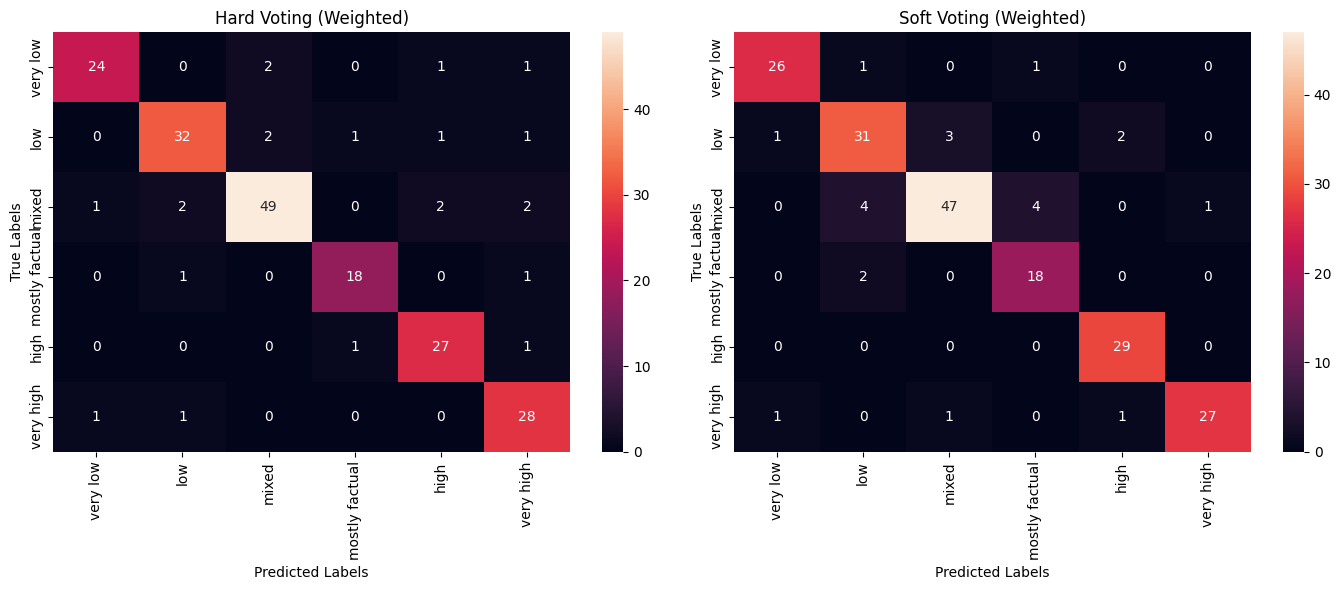

In [ ]:
models = {'BERT': bert_model_3_2, 'RoBERTa': roberta_model_3_2, 'DistilBERT': distilbert_model_3_2}
ensemble(models, distilbert_ids, device, PARAMETR_FOR_PREPARE, 50)

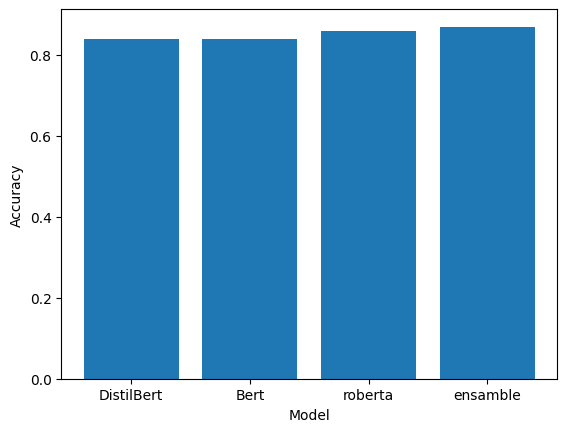

In [126]:

plt.bar(['DistilBert','Bert','roberta', 'ensamble'], [0.84,0.84, 0.86, 0.87])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

# Task 3.3 (Dataset 2728)

# DistilBERT

**Baseline**

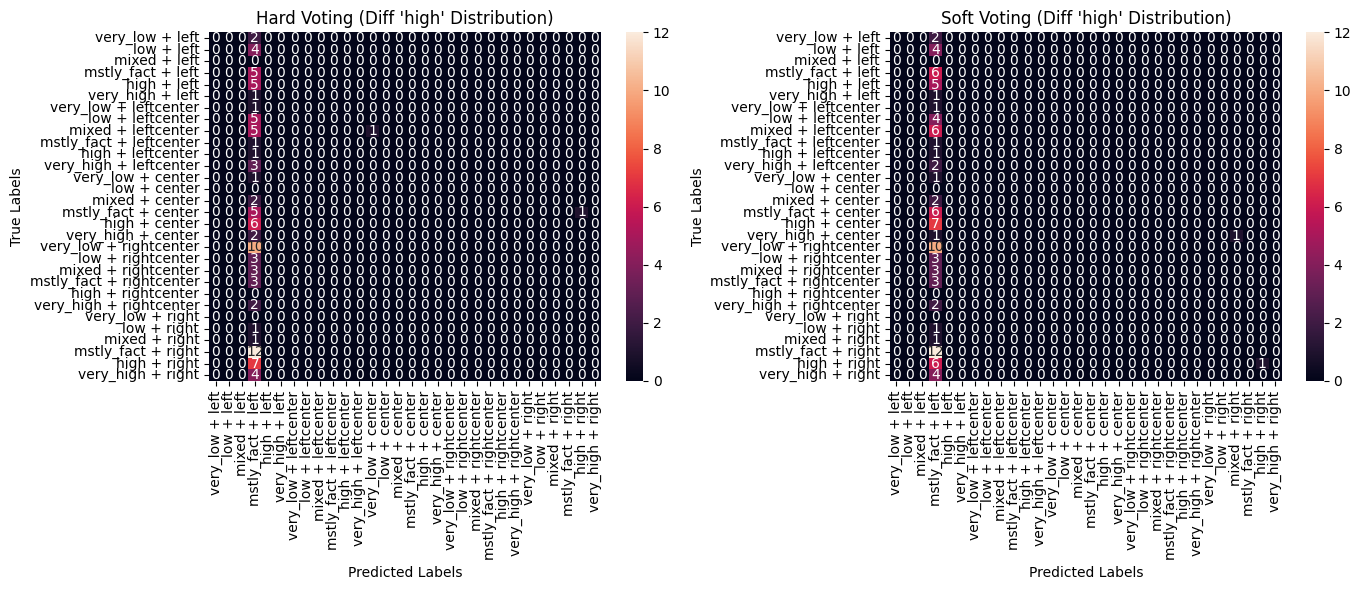

In [ ]:
get_baseline(distilbert_ids, PARAMETR_FOR_PREPARE, distilbert_name, distilbert_tokenizer, distilbert_classifire, device, 200)

**Trained model**

<function matplotlib.pyplot.show(close=None, block=None)>

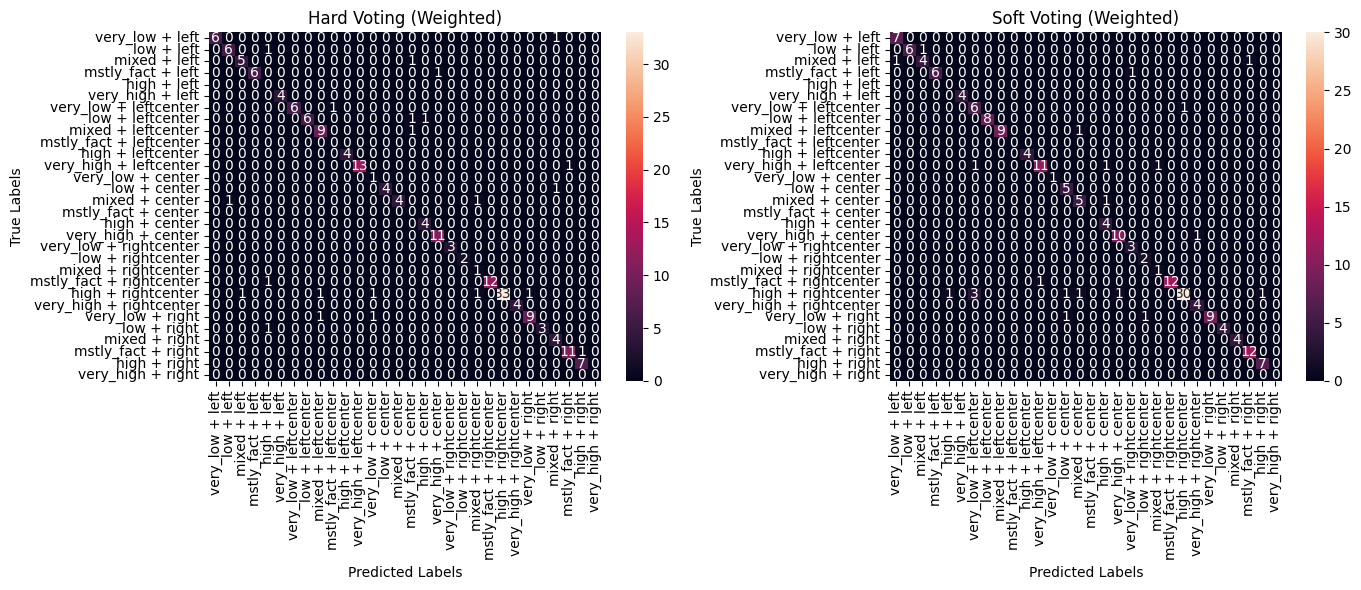

In [ ]:
distilbert_model_3_3 = get_trained_model_metrics(distilbert_ids, PARAMETR_FOR_PREPARE, distilbert_name, distilbert_tokenizer, distilbert_classifire, device, distil_fact_2728_3_3, 200)

# BERT

BASELINE

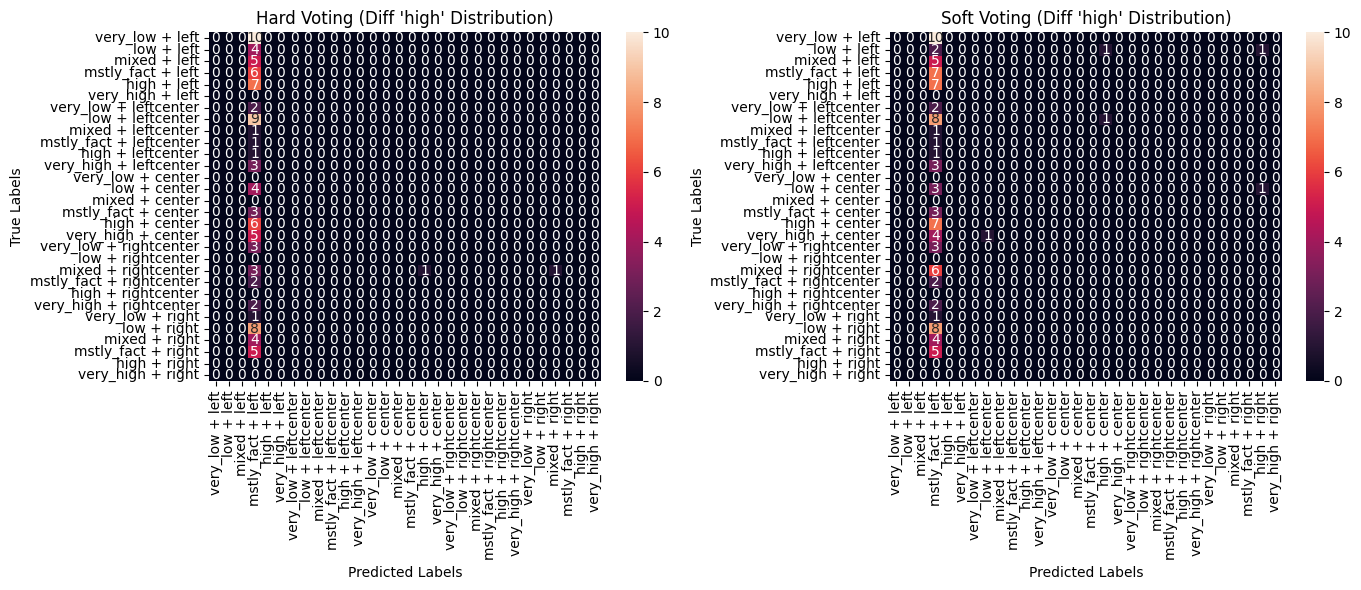

In [ ]:
get_baseline(bert_ids, PARAMETR_FOR_PREPARE, bert_name, bert_tokenizer, bert_classifire, device, 200)

TRAINED MODEL

In [ ]:
bert_model_1_3 = get_trained_model_metrics(bert_ids, PARAMETR_FOR_PREPARE, bert_name, bert_tokenizer, bert_classifire, device, bert_fact_27281_3, 200)

<function matplotlib.pyplot.show(close=None, block=None)>

# RoBERTa

BASELINE

In [ ]:
get_baseline(roberta_ids, PARAMETR_FOR_PREPARE, roberta_name, roberta_tokenizer, roberta_classifire, device, 200)

TRAINED MODEL

In [ ]:
roberta_model_3_3 = get_trained_model_metrics(roberta_ids, PARAMETR_FOR_PREPARE, roberta_name, roberta_tokenizer, roberta_classifire, device, roberta_fact_2728_3_3, 200)

<function matplotlib.pyplot.show(close=None, block=None)>

**ENSEMBLE**

<function matplotlib.pyplot.show(close=None, block=None)>

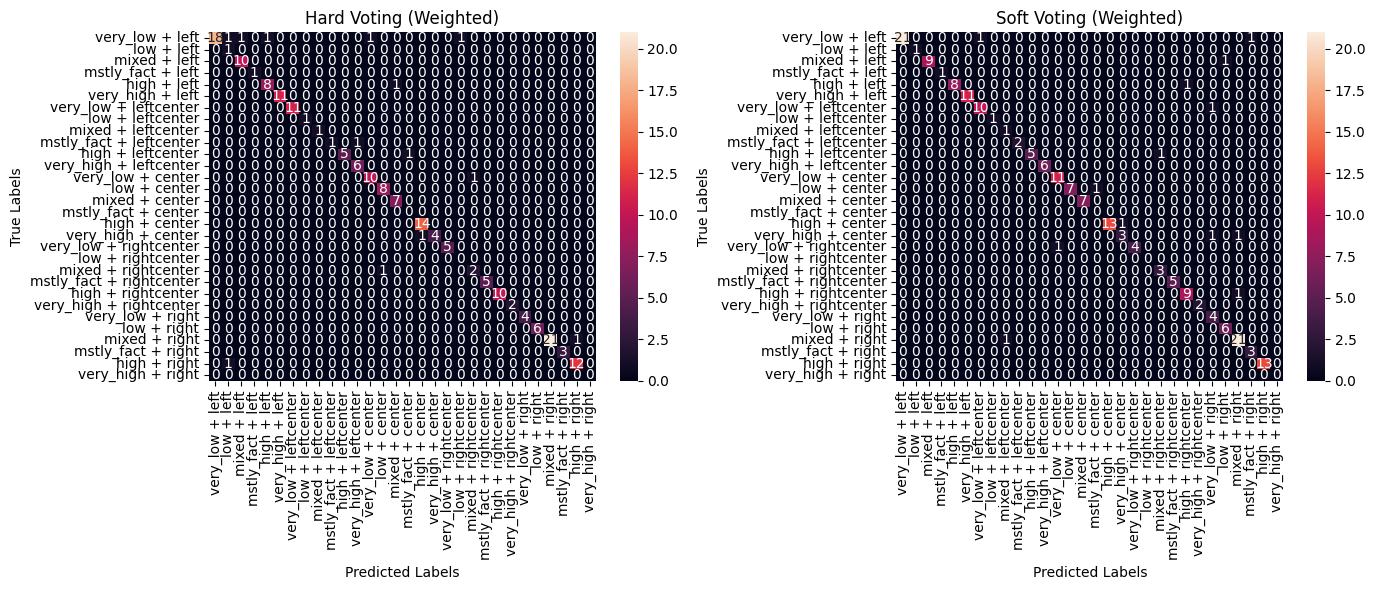

In [ ]:
models = {'BERT': bert_model_3_2, 'RoBERTa': roberta_model_3_3, 'DistilBERT': distilbert_model_3_2}
ensemble(models, distilbert_ids, device, PARAMETR_FOR_PREPARE, 50)